In [0]:
### Import statements
import torch
import torchvision
import torchvision.transforms as transforms

dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0") # uncomment to run on GPU

import numpy as np
import matplotlib.pyplot as plt

# The following causes all output to be displayed, not just output from final procedure to run
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
### Load data - taken directly from tutorial

# Load images as Tensor objects and normalize to range [-1,1]
augmented_transform = transforms.Compose(
    [transforms.RandomChoice([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=30), transforms.RandomVerticalFlip(p=0.5)]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# DataLoader simplifies minibatch SGD by returning a randomly-selected batch of training examples for each call to dataiter.next()
# Batch size given by batch_size parameter
batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augmented_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# One-hot encoding of class labels
#classes = (torch.tensor([1,0,0,0,0,0,0,0,0,0]), torch.tensor([0,1,0,0,0,0,0,0,0,0]),
#           torch.tensor([0,0,1,0,0,0,0,0,0,0]), torch.tensor([0,0,0,1,0,0,0,0,0,0]),
#           torch.tensor([0,0,0,0,1,0,0,0,0,0]), torch.tensor([0,0,0,0,0,1,0,0,0,0]),
#           torch.tensor([0,0,0,0,0,0,1,0,0,0]), torch.tensor([1,0,0,0,0,0,0,1,0,0]),
#           torch.tensor([0,0,0,0,0,0,0,0,1,0]), torch.tensor([0,0,0,0,0,0,0,0,0,1]))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


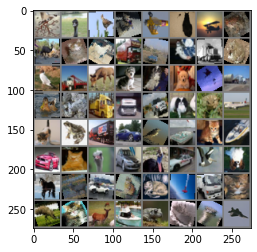

 deer  bird  bird   cat


In [0]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
### OneLayerMLP implements multilayer perceptron with single hidden layer

class OneLayerSigMLP:
  """Implements MLP with one hidden layer. Uses sigmoid activation function for hidden layer."""

  def __init__(self,
               width, # number of units in hidden layer
               input_dim, # dimensionality of input data
               n_classes, # number of classes in data
               lambd, # controls strength of L2 regularization - large lambda means stronger regularization
               epochs, # number of epochs to train model
               rate, # learning rate
               batch_size # batch size
               ):
    """Creates new instance of class OneLayerSigMLP."""
    self.width = width
    self.lambd = lambd
    self.D = input_dim
    self.C = n_classes
    self.epochs = epochs
    self.rate = rate
    self.batch_size = batch_size
    # randomly initialize weights
    self.V = torch.randn(self.D,self.width,device=device,dtype=dtype) # Dx(width) tensor
    self.W = torch.randn(self.width,self.C,device=device,dtype=dtype) # (width)xC matrix

  def sig(self,
          X # NxD tensor
          ):
    """Computes sigmoid function of each component of X"""
    sig = 1/(1+torch.exp(-1*X))
    return sig # NxD tensor

  def sig_grad(self,
               X # NxD tensor
               ):
    """Computes gradient of sigmoid function, evaluated at each component of X"""
    sig_grad = self.sig(X)*(1-self.sig(X))
    return sig_grad # NxD tensor

  def softmax(self,
              z # NxC tensor
              ):
    """Computes softmax of NxC tensor"""
    z_0 = z - torch.max(z,1,keepdim=True)[0] # subtract max of z_i's from each entry of z to improve numerical stability
    y_hat = torch.exp(z_0)
    y_hat = y_hat/torch.sum(y_hat,1,keepdim=True)
    return y_hat # NxC tensor

  def categorical_loss(self,
           y_hat, # NxC tensor
           y # NxC tensor - one-hot encoded labels
           ):
    """Computes categorical cross-entropy loss of prediction y_hat given true label y"""
    losses = torch.sum(y*torch.log(y_hat),1,keepdim=True) # Nx1 tensor of losses for each of the N examples
    loss = torch.mean(losses)
    return loss # 1x1 tensor

  def gradients(self,
                X, # NXD tensor of training examples
                y, # NxC tensor of true labels
                V, # Dx(width) tensor of input weights
                W  # (width)xC tensor of output weights
                ):
    """Computes the gradient of the MLP's loss"""

    # Forward pass to compute required values
    Z = self.sig(torch.mm(X,V)) # Nx(width)
    N = X.size()[0]
    y_hat = self.softmax(torch.mm(Z,W)) # NxC

    # Now compute gradients
    dy = y_hat - y # NxC
    dW = torch.mm(torch.t(Z),dy)/N + (self.lambd/N)*W # (width)xC - second term is gradient of L2 regularizer
    dZ = torch.mm(dy,torch.t(W)) # Nx(width)
    dV = torch.mm(torch.t(X), dZ*Z*(1-Z))/N + (self.lambd/N)*V # Dx(width) - second term is gradient of L2 regularizer
    return dW,dV

  def cost(self,
           X, # NxD tensor of training examples
           y, # NxC tensor of labels
           V, # Dx(width) tensor of input weights
           W  # (width)xC tensor of output weights
           ):
    """Computes categorical cross-entropy cost"""
    Q = torch.mm(X,V) # Nx(width)
    Z = self.sig(Q) # Nx(width)
    U = torch.mm(Z,W) # NxC
    y_hat = self.softmax(U)
    loss = -1*torch.mean(torch.sum(U*y,1) - torch.logsumexp(U,1))
    return loss


  def fit(self,
          ):
    """Trains the neural network using minibatch SGD with L2 regularization. Uses CIFAR-10 training set."""

    # First generate vector of losses to track progress
    loss_values = np.array([])
    iter_num = np.array([])

    # number of iterations is equal to epochs*(training_size)/(batch_size)
    iters_per_epoch = np.floor((40000/self.batch_size))
    n_iters = self.epochs*iters_per_epoch

    W = self.W
    V = self.V

    # now carry out SGD
    iters = 0
    while iters<n_iters:

      # Generate new dataiter object just before each epoch finishes
      if iters%iters_per_epoch == 0:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        dataiter = iter(trainloader)  

      # Generate minibatch of N training examples and flatten them into an NxD tensor
      images,labels = dataiter.next()
      X = torch.flatten(images,start_dim=1)
      # Convert X to cuda - comment out following line if running on CPU
      X = X.float().cuda()

      # Convert labels to one-hot format
      y = torch.zeros(self.batch_size,self.C)
      y.scatter_(1,labels.unsqueeze(-1).repeat(1,self.C),torch.ones(self.batch_size,self.C))
      # Convert y to cuda - comment out following line if running on CPU
      y = y.float().cuda()

      # Compute gradients and update weights
      dW,dV = self.gradients(X,y,V,W)
      W = W - self.rate*dW
      V = V - self.rate*dV

      # Compute loss every 100 iterations
      if iters%100 == 0:
        iter_num = np.append(iter_num,iters)
        loss_values = np.append(loss_values,self.cost(X,y,V,W).cpu())
        plt.plot(iter_num,loss_values)
        plt.xlabel('Number of iterations')
        plt.ylabel('Training loss')
        plt.title('Training loss: Best sigmoid MLP')
      iters = iters+1

    self.W = W
    self.V = V
    return iter_num,loss_values

  def predict(self,
              X_in, # NxD tensor of test features
              ):
    """Generates NxC tensor of predictions from MLP with current weights given NxD tensor of features"""
    Q = torch.mm(X_in,self.V) # Nx(width)
    Z = self.sig(Q) # Nx(width)
    U = torch.mm(Z,self.W) # NxC
    y_hat = self.softmax(U)
    return y_hat

  def evaluate_acc(self,
                   y_hat, # NxC tensor of predictions
                   y_true, # NxC tensor of true labels
                   ):
    """Evaluates model accuracy on NxC tensor of predictions y_hat given true labels y_true"""
    # first round predictions
    max_indices = torch.argmax(y_hat,dim=1).cuda()
    rounded = torch.zeros(y_hat.size()[0],self.C).float().cuda()
    rounded.scatter_(1,max_indices.unsqueeze(-1).repeat(1,self.C),torch.ones(y_hat.size()[0],self.C).float().cuda())

    # now compute mean accuracy
    # note that if a prediction is not equal to the true label for some instance (i.e. pred = [0,0,1,0] and true = [0,1,0,0]) then 1 norm of (pred-true) is 2
    diffs = 0.5*torch.norm(rounded-y_true,p=1,dim=1)
    acc = 100*(1-torch.mean(diffs))
    return acc



In [0]:
### OneLayerMLP implements multilayer perceptron with single hidden layer

class OneLayerReLUMLP:
  """Implements MLP with one hidden layer. Uses ReLU activation function for hidden layer."""

  def __init__(self,
               width, # number of units in hidden layer
               input_dim, # dimensionality of input data
               n_classes, # number of classes in data
               lambd, # controls strength of L2 regularization - large lambda means stronger regularization
               epochs, # number of epochs to train model
               rate, # learning rate
               batch_size # batch size
               ):
    """Creates new instance of class OneLayerSigMLP."""
    self.width = width
    self.lambd = lambd
    self.D = input_dim
    self.C = n_classes
    self.epochs = epochs
    self.rate = rate
    self.batch_size = batch_size
    # randomly initialize weights
    self.V = torch.randn(self.D,self.width,device=device,dtype=dtype) # Dx(width) tensor
    self.W = torch.randn(self.width,self.C,device=device,dtype=dtype) # (width)xC matrix

  def relu(self,
          X # NxD tensor
          ):
    """Computes ReLU of each component of X"""
    relu = X
    relu[relu<0] = 0
    return relu # NxD tensor

  def sig_grad(self,
               X # NxD tensor
               ):
    """Computes gradient of sigmoid function, evaluated at each component of X"""
    sig_grad = self.sig(X)*(1-self.sig(X))
    return sig_grad # NxD tensor

  def softmax(self,
              z # NxC tensor
              ):
    """Computes softmax of NxC tensor"""
    z_0 = z - torch.max(z,1,keepdim=True)[0] # subtract max of z_i's from each entry of z to improve numerical stability
    y_hat = torch.exp(z_0)
    y_hat = y_hat/torch.sum(y_hat,1,keepdim=True)
    return y_hat # NxC tensor

  def categorical_loss(self,
           y_hat, # NxC tensor
           y # NxC tensor - one-hot encoded labels
           ):
    """Computes categorical cross-entropy loss of prediction y_hat given true label y"""
    losses = torch.sum(y*torch.log(y_hat),1,keepdim=True) # Nx1 tensor of losses for each of the N examples
    loss = torch.mean(losses)
    return loss # 1x1 tensor

  def gradients(self,
                X, # NXD tensor of training examples
                y, # NxC tensor of true labels
                V, # Dx(width) tensor of input weights
                W  # (width)xC tensor of output weights
                ):
    """Computes the gradient of the MLP's loss"""

    # Forward pass to compute required values
    Q = torch.mm(X,V)
    Z = self.relu(Q) # Nx(width)
    N = X.size()[0]
    y_hat = self.softmax(torch.mm(Z,W)) # NxC

    # Now compute gradients
    relu_grad = torch.ones(N,self.width).float().cuda()
    relu_grad[Q<=0] = 0
    dy = y_hat - y # NxC
    dW = torch.mm(torch.t(Z),dy)/N + (self.lambd/N)*W # (width)xC - second term is gradient of L2 regularizer
    dZ = torch.mm(dy,torch.t(W)) # Nx(width)
    dV = torch.mm(torch.t(X), dZ*relu_grad)/N + (self.lambd/N)*V # Dx(width) - second term is gradient of L2 regularizer
    return dW,dV

  def cost(self,
           X, # NxD tensor of training examples
           y, # NxC tensor of labels
           V, # Dx(width) tensor of input weights
           W  # (width)xC tensor of output weights
           ):
    """Computes categorical cross-entropy cost"""
    Q = torch.mm(X,V) # Nx(width)
    Z = self.relu(Q) # Nx(width)
    U = torch.mm(Z,W) # NxC
    y_hat = self.softmax(U)
    loss = -1*torch.mean(torch.sum(U*y,1) - torch.logsumexp(U,1))
    return loss


  def fit(self,
          ):
    """Trains the neural network using minibatch SGD with L2 regularization. Uses CIFAR-10 training set."""

    # First generate vector of losses to track progress
    loss_values = np.array([])
    iter_num = np.array([])

    # number of iterations is equal to epochs*(training_size)/(batch_size)
    iters_per_epoch = np.floor((40000/self.batch_size))
    n_iters = self.epochs*iters_per_epoch

    W = self.W
    V = self.V

    # now carry out SGD
    iters = 0
    plt.figure()
    while iters<n_iters:

      # Generate new dataiter object just before each epoch finishes
      if iters%iters_per_epoch == 0:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        dataiter = iter(trainloader)  

      # Generate minibatch of N training examples and flatten them into an NxD tensor
      images,labels = dataiter.next()
      X = torch.flatten(images,start_dim=1)
      # Convert X to cuda - comment out following line if running on CPU
      X = X.float().cuda()

      # Convert labels to one-hot format
      y = torch.zeros(self.batch_size,self.C)
      y.scatter_(1,labels.unsqueeze(-1).repeat(1,self.C),torch.ones(self.batch_size,self.C))
      # Convert y to cuda - comment out following line if running on CPU
      y = y.float().cuda()

      # Compute gradients and update weights
      dW,dV = self.gradients(X,y,V,W)
      W = W - self.rate*dW
      V = V - self.rate*dV

      # Compute loss every 100 iterations
      if iters%100 == 0:
        iter_num = np.append(iter_num,iters)
        loss_values = np.append(loss_values,self.cost(X,y,V,W).cpu())
        plt.plot(iter_num,loss_values)
        plt.xlabel('Number of iterations')
        plt.ylabel('Training loss')
        plt.title('Training loss: Best ReLU MLP')
      iters = iters+1

    self.W = W
    self.V = V
    return iter_num,loss_values

  def predict(self,
              X_in, # NxD tensor of test features
              ):
    """Generates NxC tensor of predictions from MLP with current weights given NxD tensor of features"""
    Q = torch.mm(X_in,self.V) # Nx(width)
    Z = self.relu(Q) # Nx(width)
    U = torch.mm(Z,self.W) # NxC
    y_hat = self.softmax(U)
    return y_hat

  def evaluate_acc(self,
                   y_hat, # NxC tensor of predictions
                   y_true, # NxC tensor of true labels
                   ):
    """Evaluates model accuracy on NxC tensor of predictions y_hat given true labels y_true"""
    # first round predictions
    max_indices = torch.argmax(y_hat,dim=1).cuda()
    rounded = torch.zeros(y_hat.size()[0],self.C).float().cuda()
    rounded.scatter_(1,max_indices.unsqueeze(-1).repeat(1,self.C),torch.ones(y_hat.size()[0],self.C).float().cuda())

    # now compute mean accuracy
    # note that if a prediction is not equal to the true label for some instance (i.e. pred = [0,0,1,0] and true = [0,1,0,0]) then 1 norm of (pred-true) is 2
    diffs = 0.5*torch.norm(rounded-y_true,p=1,dim=1)
    acc = 100*(1-torch.mean(diffs))
    return acc



Files already downloaded and verified
Files already downloaded and verified


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0, rate=0.1. Validation accuracy: 0.32910001277923584


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0, rate=0.2. Validation accuracy: 0.3409000039100647


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0, rate=0.3. Validation accuracy: 0.296999990940094


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.25, rate=0.1. Validation accuracy: 0.4147000312805176


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.25, rate=0.2. Validation accuracy: 0.4172000288963318


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.25, rate=0.3. Validation accuracy: 0.38429999351501465


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.5, rate=0.1. Validation accuracy: 0.38609999418258667


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.5, rate=0.2. Validation accuracy: 0.36309999227523804


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.5, rate=0.3. Validation accuracy: 0.3614000082015991


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.75, rate=0.1. Validation accuracy: 0.37540000677108765


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.75, rate=0.2. Validation accuracy: 0.359499990940094


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=0.75, rate=0.3. Validation accuracy: 0.3393999934196472


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=250, L2=1, rate=0.1. Validation accuracy: 0.3517000079154968


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=1, rate=0.2. Validation accuracy: 0.3363000154495239


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=1, rate=0.3. Validation accuracy: 0.3050000071525574


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=250, L2=1.5, rate=0.1. Validation accuracy: 0.34119999408721924


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=250, L2=1.5, rate=0.2. Validation accuracy: 0.3409000039100647


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=250, L2=1.5, rate=0.3. Validation accuracy: 0.1868000030517578


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=2, rate=0.1. Validation accuracy: 0.3199999928474426


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=250, L2=2, rate=0.2. Validation accuracy: 0.3222000002861023


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=250, L2=2, rate=0.3. Validation accuracy: 0.2872999906539917


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0, rate=0.1. Validation accuracy: 0.29739999771118164


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0, rate=0.2. Validation accuracy: 0.2962999939918518


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0, rate=0.3. Validation accuracy: 0.2962000370025635


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=500, L2=0.25, rate=0.1. Validation accuracy: 0.3500000238418579


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0.25, rate=0.2. Validation accuracy: 0.3319000005722046


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=500, L2=0.25, rate=0.3. Validation accuracy: 0.35199999809265137


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0.5, rate=0.1. Validation accuracy: 0.38130003213882446


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0.5, rate=0.2. Validation accuracy: 0.3371000289916992


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0.5, rate=0.3. Validation accuracy: 0.2955999970436096


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0.75, rate=0.1. Validation accuracy: 0.3548000454902649


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0.75, rate=0.2. Validation accuracy: 0.30800002813339233


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=0.75, rate=0.3. Validation accuracy: 0.24300003051757812


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=500, L2=1, rate=0.1. Validation accuracy: 0.3659999966621399


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=1, rate=0.2. Validation accuracy: 0.27880001068115234


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=1, rate=0.3. Validation accuracy: 0.19560003280639648


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=500, L2=1.5, rate=0.1. Validation accuracy: 0.33090001344680786


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=1.5, rate=0.2. Validation accuracy: 0.22450000047683716


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=1.5, rate=0.3. Validation accuracy: 0.2232000231742859


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=500, L2=2, rate=0.1. Validation accuracy: 0.28189998865127563


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=2, rate=0.2. Validation accuracy: 0.24150002002716064


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=500, L2=2, rate=0.3. Validation accuracy: 0.26080000400543213


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=750, L2=0, rate=0.1. Validation accuracy: 0.28850001096725464


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0, rate=0.2. Validation accuracy: 0.29840004444122314


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0, rate=0.3. Validation accuracy: 0.31679999828338623


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0.25, rate=0.1. Validation accuracy: 0.3906000256538391


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0.25, rate=0.2. Validation accuracy: 0.40880000591278076


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0.25, rate=0.3. Validation accuracy: 0.3655000329017639


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0.5, rate=0.1. Validation accuracy: 0.30000001192092896


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0.5, rate=0.2. Validation accuracy: 0.27720004320144653


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0.5, rate=0.3. Validation accuracy: 0.2542000412940979


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0.75, rate=0.1. Validation accuracy: 0.32450002431869507


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=750, L2=0.75, rate=0.2. Validation accuracy: 0.31139999628067017


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=0.75, rate=0.3. Validation accuracy: 0.24490004777908325


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=1, rate=0.1. Validation accuracy: 0.33469998836517334


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=1, rate=0.2. Validation accuracy: 0.24180001020431519


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=1, rate=0.3. Validation accuracy: 0.25880002975463867


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=750, L2=1.5, rate=0.1. Validation accuracy: 0.30239999294281006


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=1.5, rate=0.2. Validation accuracy: 0.18700003623962402


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=1.5, rate=0.3. Validation accuracy: 0.1818000078201294


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=2, rate=0.1. Validation accuracy: 0.2591000199317932


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=2, rate=0.2. Validation accuracy: 0.23700004816055298


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=750, L2=2, rate=0.3. Validation accuracy: 0.22360002994537354


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0, rate=0.1. Validation accuracy: 0.2900000214576721


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0, rate=0.2. Validation accuracy: 0.30900001525878906


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0, rate=0.3. Validation accuracy: 0.30390000343322754


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0.25, rate=0.1. Validation accuracy: 0.3659999966621399


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0.25, rate=0.2. Validation accuracy: 0.3094000220298767


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=1000, L2=0.25, rate=0.3. Validation accuracy: 0.29590004682540894


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0.5, rate=0.1. Validation accuracy: 0.3217000365257263


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0.5, rate=0.2. Validation accuracy: 0.31220000982284546


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=1000, L2=0.5, rate=0.3. Validation accuracy: 0.19770002365112305


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0.75, rate=0.1. Validation accuracy: 0.29840004444122314


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0.75, rate=0.2. Validation accuracy: 0.27740001678466797


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=0.75, rate=0.3. Validation accuracy: 0.27230000495910645


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=1, rate=0.1. Validation accuracy: 0.26260000467300415


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=1, rate=0.2. Validation accuracy: 0.17720001935958862


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=1000, L2=1, rate=0.3. Validation accuracy: 0.18870002031326294


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=1.5, rate=0.1. Validation accuracy: 0.26190000772476196


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=1.5, rate=0.2. Validation accuracy: 0.24080002307891846


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=1.5, rate=0.3. Validation accuracy: 0.18660002946853638


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=2, rate=0.1. Validation accuracy: 0.25300002098083496


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=2, rate=0.2. Validation accuracy: 0.2240999937057495


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1000, L2=2, rate=0.3. Validation accuracy: 0.20500004291534424


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0, rate=0.1. Validation accuracy: 0.2939000129699707


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0, rate=0.2. Validation accuracy: 0.28620004653930664


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0, rate=0.3. Validation accuracy: 0.31540000438690186


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0.25, rate=0.1. Validation accuracy: 0.28940004110336304


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=1500, L2=0.25, rate=0.2. Validation accuracy: 0.2738000154495239


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0.25, rate=0.3. Validation accuracy: 0.3050000071525574


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=1500, L2=0.5, rate=0.1. Validation accuracy: 0.3063000440597534


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0.5, rate=0.2. Validation accuracy: 0.28839999437332153


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0.5, rate=0.3. Validation accuracy: 0.2727000117301941


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0.75, rate=0.1. Validation accuracy: 0.2897000312805176


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0.75, rate=0.2. Validation accuracy: 0.15500003099441528


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=0.75, rate=0.3. Validation accuracy: 0.15299999713897705


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=1, rate=0.1. Validation accuracy: 0.21549999713897705


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=1, rate=0.2. Validation accuracy: 0.2419000267982483


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=1, rate=0.3. Validation accuracy: 0.241100013256073


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=1.5, rate=0.1. Validation accuracy: 0.18389999866485596


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=1.5, rate=0.2. Validation accuracy: 0.18240004777908325


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=1.5, rate=0.3. Validation accuracy: 0.17110002040863037


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=2, rate=0.1. Validation accuracy: 0.20680004358291626


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=2, rate=0.2. Validation accuracy: 0.22510004043579102


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=1500, L2=2, rate=0.3. Validation accuracy: 0.1966000199317932


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0, rate=0.1. Validation accuracy: 0.2835000157356262


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=2000, L2=0, rate=0.2. Validation accuracy: 0.3117000460624695


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=2000, L2=0, rate=0.3. Validation accuracy: 0.34970003366470337


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0.25, rate=0.1. Validation accuracy: 0.34960001707077026


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0.25, rate=0.2. Validation accuracy: 0.2752000093460083


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=2000, L2=0.25, rate=0.3. Validation accuracy: 0.26100003719329834


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0.5, rate=0.1. Validation accuracy: 0.3359000086784363


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0.5, rate=0.2. Validation accuracy: 0.22990000247955322


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0.5, rate=0.3. Validation accuracy: 0.2840999960899353


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0.75, rate=0.1. Validation accuracy: 0.1924000382423401


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0.75, rate=0.2. Validation accuracy: 0.2459999918937683


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=0.75, rate=0.3. Validation accuracy: 0.22769999504089355


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=1, rate=0.1. Validation accuracy: 0.2355000376701355


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=1, rate=0.2. Validation accuracy: 0.1949000358581543


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=1, rate=0.3. Validation accuracy: 0.1439000368118286


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=2000, L2=1.5, rate=0.1. Validation accuracy: 0.23350000381469727


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=1.5, rate=0.2. Validation accuracy: 0.22640001773834229


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=1.5, rate=0.3. Validation accuracy: 0.17590004205703735


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=2, rate=0.1. Validation accuracy: 0.2337999939918518


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=2000, L2=2, rate=0.2. Validation accuracy: 0.15720003843307495


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2000, L2=2, rate=0.3. Validation accuracy: 0.18910002708435059


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0, rate=0.1. Validation accuracy: 0.29269999265670776


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0, rate=0.2. Validation accuracy: 0.30309998989105225


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0, rate=0.3. Validation accuracy: 0.3041999936103821


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.25, rate=0.1. Validation accuracy: 0.2808000445365906


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.25, rate=0.2. Validation accuracy: 0.3046000003814697


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.25, rate=0.3. Validation accuracy: 0.28450000286102295


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.5, rate=0.1. Validation accuracy: 0.2710000276565552


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.5, rate=0.2. Validation accuracy: 0.20329999923706055


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.5, rate=0.3. Validation accuracy: 0.27320003509521484


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.75, rate=0.1. Validation accuracy: 0.2639000415802002


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.75, rate=0.2. Validation accuracy: 0.19179999828338623


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=0.75, rate=0.3. Validation accuracy: 0.24880003929138184


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=1, rate=0.1. Validation accuracy: 0.2093999981880188


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=1, rate=0.2. Validation accuracy: 0.19450002908706665


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=1, rate=0.3. Validation accuracy: 0.19020003080368042


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=1.5, rate=0.1. Validation accuracy: 0.15460002422332764


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=1.5, rate=0.2. Validation accuracy: 0.20829999446868896


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=1.5, rate=0.3. Validation accuracy: 0.1916000247001648


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=2, rate=0.1. Validation accuracy: 0.18970000743865967


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=2, rate=0.2. Validation accuracy: 0.2290000319480896


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=2500, L2=2, rate=0.3. Validation accuracy: 0.163100004196167


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0, rate=0.1. Validation accuracy: 0.29770004749298096


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0, rate=0.2. Validation accuracy: 0.30090004205703735


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0, rate=0.3. Validation accuracy: 0.30020004510879517


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.25, rate=0.1. Validation accuracy: 0.34400004148483276


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.25, rate=0.2. Validation accuracy: 0.26010000705718994


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.25, rate=0.3. Validation accuracy: 0.28119999170303345


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.5, rate=0.1. Validation accuracy: 0.2621000409126282


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.5, rate=0.2. Validation accuracy: 0.23840004205703735


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.5, rate=0.3. Validation accuracy: 0.24720001220703125


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.75, rate=0.1. Validation accuracy: 0.1559000015258789


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.75, rate=0.2. Validation accuracy: 0.24000000953674316


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=0.75, rate=0.3. Validation accuracy: 0.20759999752044678


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=1, rate=0.1. Validation accuracy: 0.19450002908706665


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=1, rate=0.2. Validation accuracy: 0.18080002069473267


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=1, rate=0.3. Validation accuracy: 0.23440003395080566


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=1.5, rate=0.1. Validation accuracy: 0.21000003814697266


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=1.5, rate=0.2. Validation accuracy: 0.23350000381469727


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=1.5, rate=0.3. Validation accuracy: 0.1568000316619873


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer sigmoid MLP: w=3000, L2=2, rate=0.1. Validation accuracy: 0.21000003814697266


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=2, rate=0.2. Validation accuracy: 0.15479999780654907


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer sigmoid MLP: w=3000, L2=2, rate=0.3. Validation accuracy: 0.19290000200271606


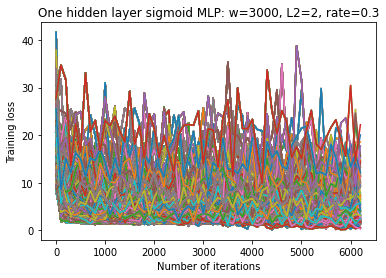

In [0]:
### Script for running experiments - one hidden layer sigmoid

### Start by loading train and test sets. Split trainset into training data (80% of original data) and validation set (20%)

# Load images as Tensor objects and normalize to range [-1,1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# DataLoader simplifies minibatch SGD by returning a randomly-selected batch of training examples for each call to dataiter.next()
# Batch size given by batch_size parameter
batch_size = 64
traindata = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Split training set into train (40,000 examples) and validation (10,000 examples)
trainset, valset = torch.utils.data.random_split(traindata, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define parameters to test

widths = [250,500,750,1000,1500,2000,2500,3000]
regularization = [0,0.25,0.5,0.75,1,1.5,2]
lr = [0.1,0.2,0.3]

for w in widths:
  for reg in regularization:
    for rate in lr:
      lc_title = 'One hidden layer sigmoid MLP: w=' + str(w) + ', L2=' + str(reg) + ', rate=' + str(rate)
      # Train MLP
      neural_network = OneLayerSigMLP(w,3072,10,reg,10,rate,batch_size)
      iter_num,loss_values = neural_network.fit()

      # Compute validation loss
      valloader = torch.utils.data.DataLoader(valset, batch_size=10000,
                                         shuffle=True, num_workers=2)
      valiter = iter(valloader) 
      # Generate minibatch of N training examples and flatten them into an NxD tensor
      val_images,val_labels = valiter.next()
      X_val = torch.flatten(val_images,start_dim=1)
      X_val = X_val.float().cuda()

      # Convert labels to one-hot format
      batch = 10000
      C = 10
      y_val = torch.zeros(batch,C)
      y_val.scatter_(1,val_labels.unsqueeze(-1).repeat(1,C),torch.ones(batch,C))
      y_val = y_val.float().cuda()

      y_hat_val = neural_network.predict(X_val)
      acc = neural_network.evaluate_acc(y_hat_val,y_val)
      print(lc_title + '. Validation accuracy: ' + str(acc.item()))


Files already downloaded and verified
Files already downloaded and verified


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=250, L2=0, rate=0.1. Validation accuracy: 0.24239999055862427


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0, rate=0.2. Validation accuracy: 0.23849999904632568


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=250, L2=0, rate=0.3. Validation accuracy: 0.2199000120162964


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.25, rate=0.1. Validation accuracy: 0.4646000266075134


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.25, rate=0.2. Validation accuracy: 0.4261000156402588


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.25, rate=0.3. Validation accuracy: 0.38999998569488525


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.5, rate=0.1. Validation accuracy: 0.48000001907348633


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.5, rate=0.2. Validation accuracy: 0.4172999858856201


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.5, rate=0.3. Validation accuracy: 0.3546000123023987


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.75, rate=0.1. Validation accuracy: 0.4545000195503235


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.75, rate=0.2. Validation accuracy: 0.4029000401496887


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=0.75, rate=0.3. Validation accuracy: 0.346500039100647


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=1, rate=0.1. Validation accuracy: 0.4618000388145447


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=250, L2=1, rate=0.2. Validation accuracy: 0.4140999913215637


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=1, rate=0.3. Validation accuracy: 0.3393000364303589


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=250, L2=1.5, rate=0.1. Validation accuracy: 0.4406999945640564


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=1.5, rate=0.2. Validation accuracy: 0.36590003967285156


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=1.5, rate=0.3. Validation accuracy: 0.3095000386238098


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=2, rate=0.1. Validation accuracy: 0.4269000291824341


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=250, L2=2, rate=0.2. Validation accuracy: 0.3809000253677368


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=250, L2=2, rate=0.3. Validation accuracy: 0.34450000524520874


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0, rate=0.1. Validation accuracy: 0.29280000925064087


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0, rate=0.2. Validation accuracy: 0.2985000014305115


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0, rate=0.3. Validation accuracy: 0.2469000220298767


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0.25, rate=0.1. Validation accuracy: 0.460099995136261


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0.25, rate=0.2. Validation accuracy: 0.41930001974105835


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0.25, rate=0.3. Validation accuracy: 0.33820003271102905


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0.5, rate=0.1. Validation accuracy: 0.48830002546310425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=500, L2=0.5, rate=0.2. Validation accuracy: 0.41040003299713135


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0.5, rate=0.3. Validation accuracy: 0.3646000027656555


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0.75, rate=0.1. Validation accuracy: 0.4426000118255615


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0.75, rate=0.2. Validation accuracy: 0.41940003633499146


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=0.75, rate=0.3. Validation accuracy: 0.35280001163482666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=1, rate=0.1. Validation accuracy: 0.4569000005722046


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=1, rate=0.2. Validation accuracy: 0.42500001192092896


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=1, rate=0.3. Validation accuracy: 0.3282000422477722


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=1.5, rate=0.1. Validation accuracy: 0.4570000171661377


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=1.5, rate=0.2. Validation accuracy: 0.388700008392334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=1.5, rate=0.3. Validation accuracy: 0.352400004863739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=500, L2=2, rate=0.1. Validation accuracy: 0.4316999912261963


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=500, L2=2, rate=0.2. Validation accuracy: 0.3873000144958496


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=500, L2=2, rate=0.3. Validation accuracy: 0.3273000121116638


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0, rate=0.1. Validation accuracy: 0.357699990272522


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0, rate=0.2. Validation accuracy: 0.31050002574920654


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0, rate=0.3. Validation accuracy: 0.23620003461837769


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0.25, rate=0.1. Validation accuracy: 0.4560999870300293


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0.25, rate=0.2. Validation accuracy: 0.4575999975204468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0.25, rate=0.3. Validation accuracy: 0.3549000024795532


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=750, L2=0.5, rate=0.1. Validation accuracy: 0.4916999936103821


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0.5, rate=0.2. Validation accuracy: 0.4417000412940979


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0.5, rate=0.3. Validation accuracy: 0.37220001220703125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0.75, rate=0.1. Validation accuracy: 0.4611999988555908


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=750, L2=0.75, rate=0.2. Validation accuracy: 0.41589999198913574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=0.75, rate=0.3. Validation accuracy: 0.376800000667572


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=750, L2=1, rate=0.1. Validation accuracy: 0.4674000144004822


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=1, rate=0.2. Validation accuracy: 0.37090003490448


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=1, rate=0.3. Validation accuracy: 0.3497999906539917


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=1.5, rate=0.1. Validation accuracy: 0.4366000294685364


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=1.5, rate=0.2. Validation accuracy: 0.3931000232696533


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=750, L2=1.5, rate=0.3. Validation accuracy: 0.32590001821517944


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=2, rate=0.1. Validation accuracy: 0.41760003566741943


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=2, rate=0.2. Validation accuracy: 0.37389999628067017


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=750, L2=2, rate=0.3. Validation accuracy: 0.3030000329017639


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=1000, L2=0, rate=0.1. Validation accuracy: 0.3659999966621399


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0, rate=0.2. Validation accuracy: 0.29180002212524414


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=1000, L2=0, rate=0.3. Validation accuracy: 0.2281000018119812


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0.25, rate=0.1. Validation accuracy: 0.47360002994537354


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0.25, rate=0.2. Validation accuracy: 0.4106000065803528


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0.25, rate=0.3. Validation accuracy: 0.36239999532699585


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0.5, rate=0.1. Validation accuracy: 0.47530001401901245


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0.5, rate=0.2. Validation accuracy: 0.4118000268936157


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0.5, rate=0.3. Validation accuracy: 0.4025000333786011


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0.75, rate=0.1. Validation accuracy: 0.477400004863739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=1000, L2=0.75, rate=0.2. Validation accuracy: 0.40369999408721924


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=0.75, rate=0.3. Validation accuracy: 0.35040003061294556


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=1, rate=0.1. Validation accuracy: 0.45719999074935913


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=1, rate=0.2. Validation accuracy: 0.38130003213882446


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=1, rate=0.3. Validation accuracy: 0.3472999930381775


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=1000, L2=1.5, rate=0.1. Validation accuracy: 0.4491000175476074


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=1.5, rate=0.2. Validation accuracy: 0.3596000075340271


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=1.5, rate=0.3. Validation accuracy: 0.34940004348754883


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=2, rate=0.1. Validation accuracy: 0.4296000003814697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=2, rate=0.2. Validation accuracy: 0.3862000107765198


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1000, L2=2, rate=0.3. Validation accuracy: 0.30320000648498535


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=1500, L2=0, rate=0.1. Validation accuracy: 0.4002000093460083


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0, rate=0.2. Validation accuracy: 0.32510000467300415


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0, rate=0.3. Validation accuracy: 0.1948000192642212


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0.25, rate=0.1. Validation accuracy: 0.46399998664855957


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0.25, rate=0.2. Validation accuracy: 0.44999998807907104


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0.25, rate=0.3. Validation accuracy: 0.3896999955177307


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0.5, rate=0.1. Validation accuracy: 0.4399999976158142


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0.5, rate=0.2. Validation accuracy: 0.41589999198913574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0.5, rate=0.3. Validation accuracy: 0.35019999742507935


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0.75, rate=0.1. Validation accuracy: 0.4610000252723694


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=1500, L2=0.75, rate=0.2. Validation accuracy: 0.3866000175476074


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=1500, L2=0.75, rate=0.3. Validation accuracy: 0.3716999888420105


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=1500, L2=1, rate=0.1. Validation accuracy: 0.45670002698898315


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=1, rate=0.2. Validation accuracy: 0.42739999294281006


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=1500, L2=1, rate=0.3. Validation accuracy: 0.383400022983551


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=1.5, rate=0.1. Validation accuracy: 0.4305000305175781


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=1500, L2=1.5, rate=0.2. Validation accuracy: 0.352400004863739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=1500, L2=1.5, rate=0.3. Validation accuracy: 0.374500036239624


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=2, rate=0.1. Validation accuracy: 0.41670000553131104


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=1500, L2=2, rate=0.2. Validation accuracy: 0.38280004262924194


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=1500, L2=2, rate=0.3. Validation accuracy: 0.30160003900527954


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0, rate=0.1. Validation accuracy: 0.40570002794265747


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0, rate=0.2. Validation accuracy: 0.3172000050544739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0, rate=0.3. Validation accuracy: 0.2379000186920166


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0.25, rate=0.1. Validation accuracy: 0.43849998712539673


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0.25, rate=0.2. Validation accuracy: 0.4325000047683716


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=2000, L2=0.25, rate=0.3. Validation accuracy: 0.3160000443458557


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0.5, rate=0.1. Validation accuracy: 0.4634000062942505


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0.5, rate=0.2. Validation accuracy: 0.4514000415802002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0.5, rate=0.3. Validation accuracy: 0.3515000343322754


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0.75, rate=0.1. Validation accuracy: 0.47610002756118774


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0.75, rate=0.2. Validation accuracy: 0.3964000344276428


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=0.75, rate=0.3. Validation accuracy: 0.36090004444122314


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=1, rate=0.1. Validation accuracy: 0.45100003480911255


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=1, rate=0.2. Validation accuracy: 0.383400022983551


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=1, rate=0.3. Validation accuracy: 0.30169999599456787


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=1.5, rate=0.1. Validation accuracy: 0.43800002336502075


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=1.5, rate=0.2. Validation accuracy: 0.3822000026702881


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=1.5, rate=0.3. Validation accuracy: 0.3208000063896179


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=2000, L2=2, rate=0.1. Validation accuracy: 0.4212999939918518


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=2, rate=0.2. Validation accuracy: 0.37459999322891235


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2000, L2=2, rate=0.3. Validation accuracy: 0.3521000146865845


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0, rate=0.1. Validation accuracy: 0.43080002069473267


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0, rate=0.2. Validation accuracy: 0.26520001888275146


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0, rate=0.3. Validation accuracy: 0.28299999237060547


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.25, rate=0.1. Validation accuracy: 0.43230003118515015


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.25, rate=0.2. Validation accuracy: 0.4496999979019165


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.25, rate=0.3. Validation accuracy: 0.34540003538131714


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.5, rate=0.1. Validation accuracy: 0.4830000400543213


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.5, rate=0.2. Validation accuracy: 0.4058000445365906


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.5, rate=0.3. Validation accuracy: 0.3688000440597534


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.75, rate=0.1. Validation accuracy: 0.43810003995895386


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.75, rate=0.2. Validation accuracy: 0.4259999990463257


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=0.75, rate=0.3. Validation accuracy: 0.37790000438690186


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=1, rate=0.1. Validation accuracy: 0.46470004320144653


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=1, rate=0.2. Validation accuracy: 0.39259999990463257


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=1, rate=0.3. Validation accuracy: 0.3343999981880188


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=2500, L2=1.5, rate=0.1. Validation accuracy: 0.442300021648407


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=1.5, rate=0.2. Validation accuracy: 0.39079999923706055


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=1.5, rate=0.3. Validation accuracy: 0.31709998846054077


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=2, rate=0.1. Validation accuracy: 0.423799991607666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=2, rate=0.2. Validation accuracy: 0.39579999446868896


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=2500, L2=2, rate=0.3. Validation accuracy: 0.2784000039100647


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0, rate=0.1. Validation accuracy: 0.4034000039100647


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0, rate=0.2. Validation accuracy: 0.3088000416755676


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0, rate=0.3. Validation accuracy: 0.22940003871917725


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0.25, rate=0.1. Validation accuracy: 0.43059998750686646


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0.25, rate=0.2. Validation accuracy: 0.4277000427246094


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0.25, rate=0.3. Validation accuracy: 0.37880003452301025


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0.5, rate=0.1. Validation accuracy: 0.49090003967285156


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0.5, rate=0.2. Validation accuracy: 0.4074000120162964


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0.5, rate=0.3. Validation accuracy: 0.3587999939918518


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0.75, rate=0.1. Validation accuracy: 0.47839999198913574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=3000, L2=0.75, rate=0.2. Validation accuracy: 0.4406999945640564


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=3000, L2=0.75, rate=0.3. Validation accuracy: 0.35040003061294556


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=1, rate=0.1. Validation accuracy: 0.45810002088546753


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

One hidden layer ReLU MLP: w=3000, L2=1, rate=0.2. Validation accuracy: 0.3963000178337097


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=3000, L2=1, rate=0.3. Validation accuracy: 0.33570003509521484


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=1.5, rate=0.1. Validation accuracy: 0.4472000002861023


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=1.5, rate=0.2. Validation accuracy: 0.37490004301071167


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=1.5, rate=0.3. Validation accuracy: 0.35920000076293945


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=2, rate=0.1. Validation accuracy: 0.4294000267982483


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

One hidden layer ReLU MLP: w=3000, L2=2, rate=0.2. Validation accuracy: 0.38690000772476196


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

One hidden layer ReLU MLP: w=3000, L2=2, rate=0.3. Validation accuracy: 0.3240000009536743


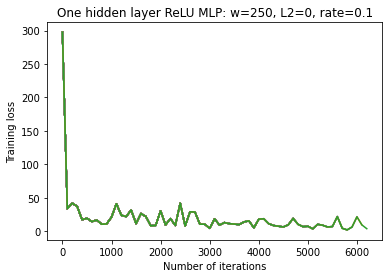

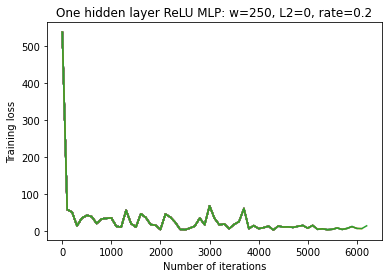

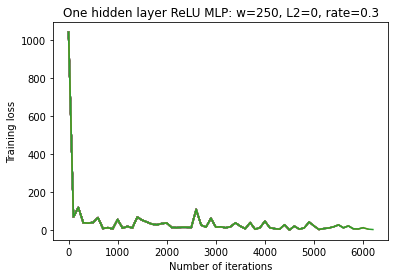

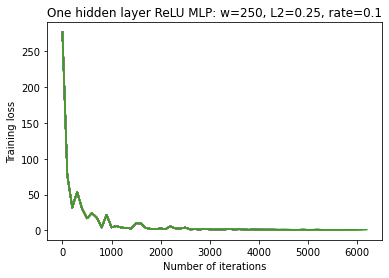

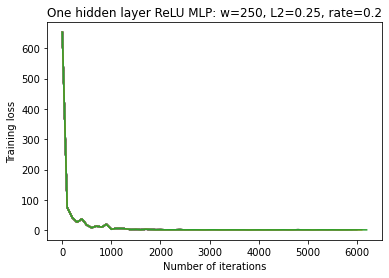

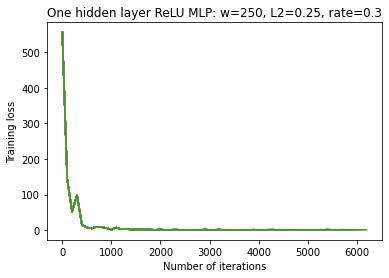

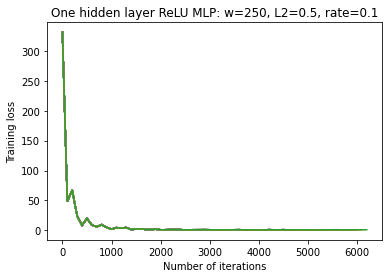

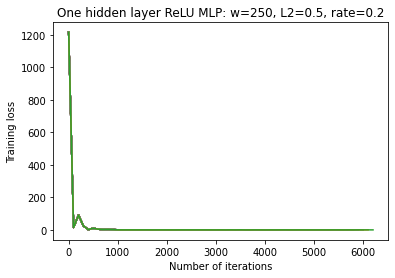

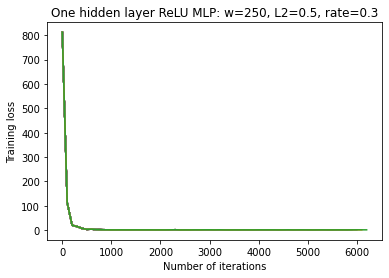

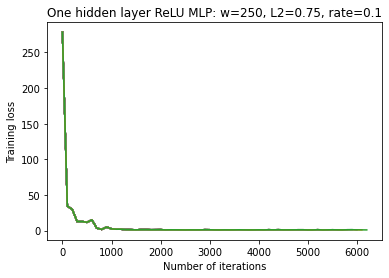

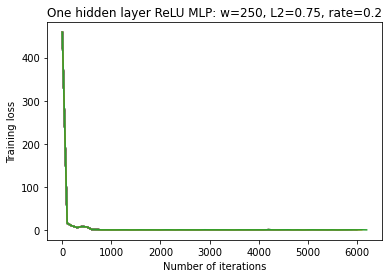

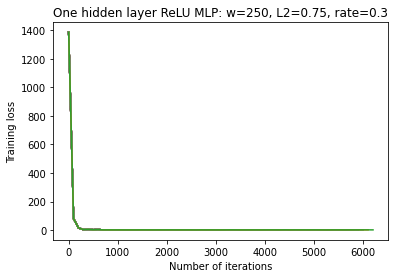

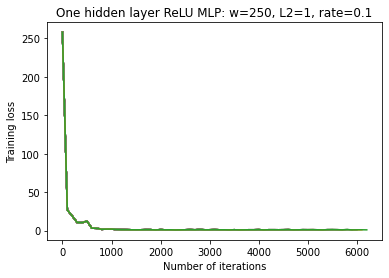

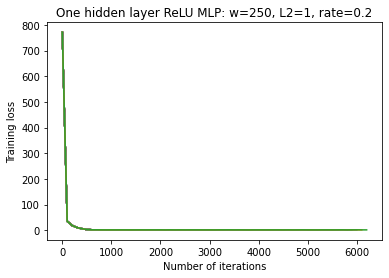

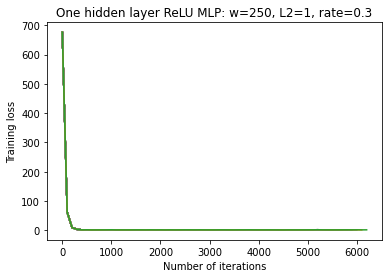

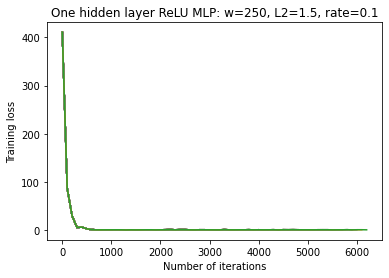

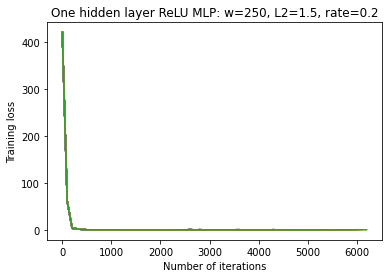

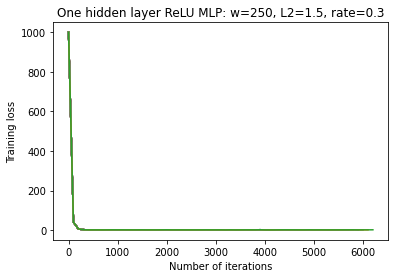

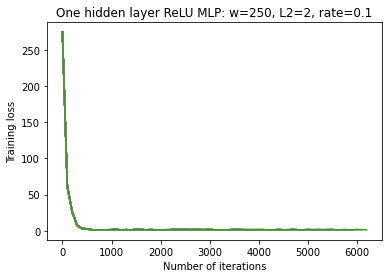

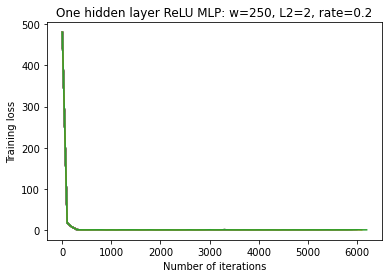

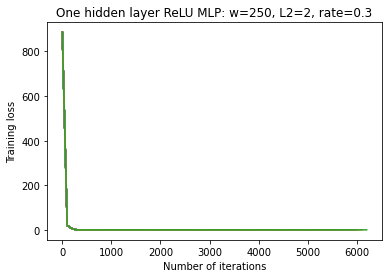

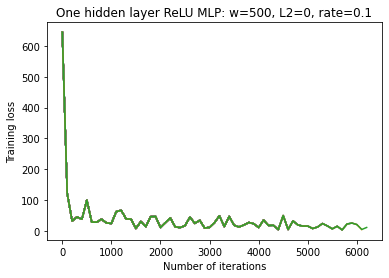

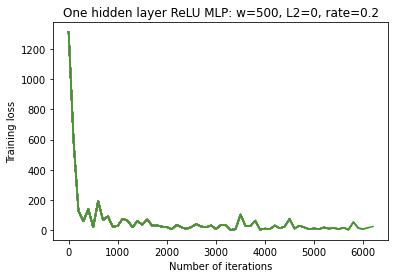

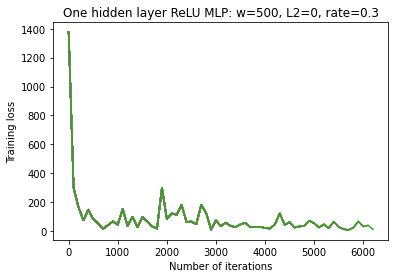

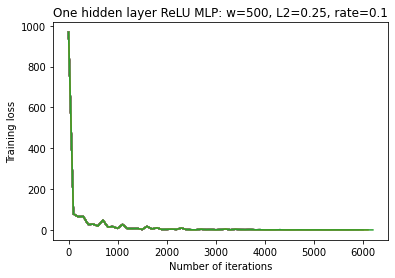

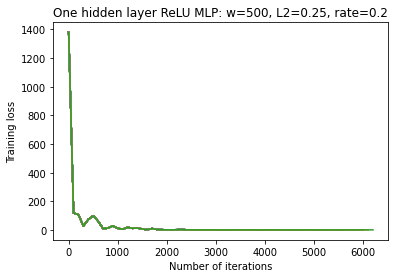

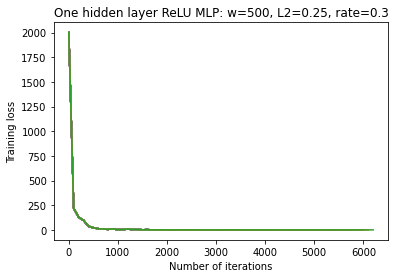

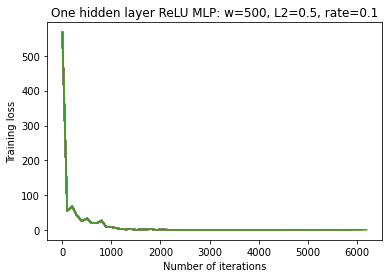

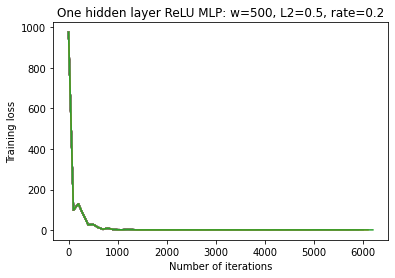

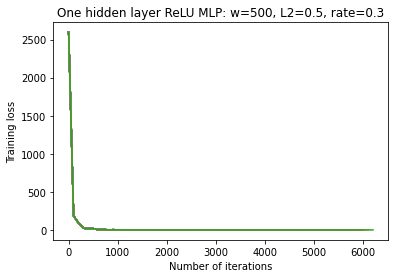

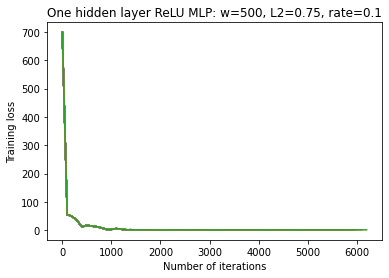

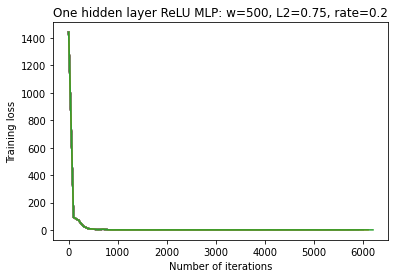

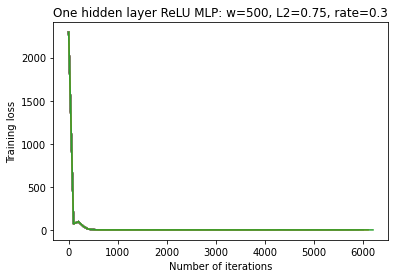

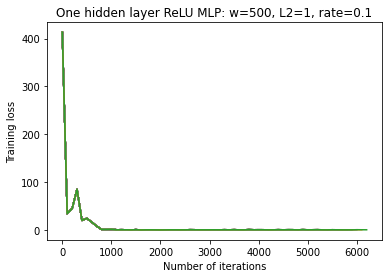

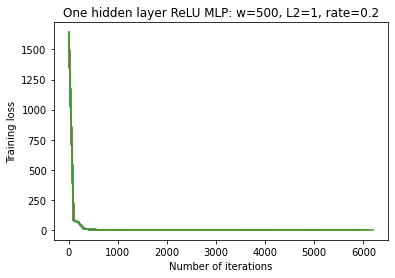

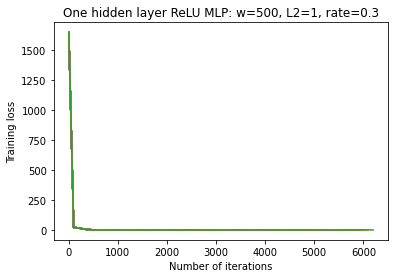

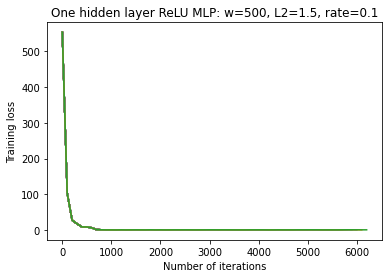

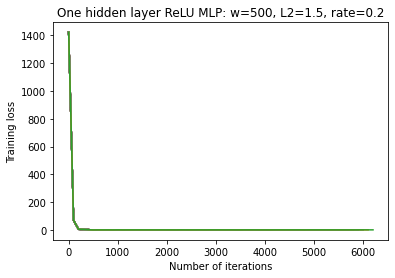

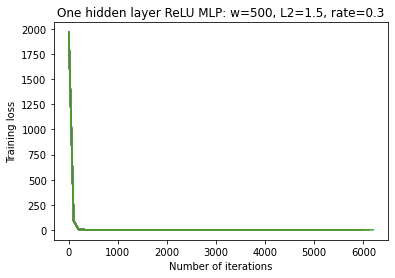

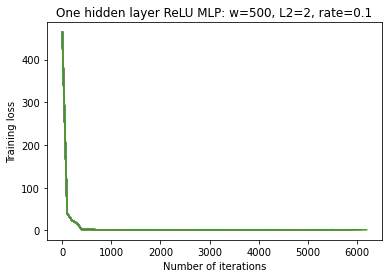

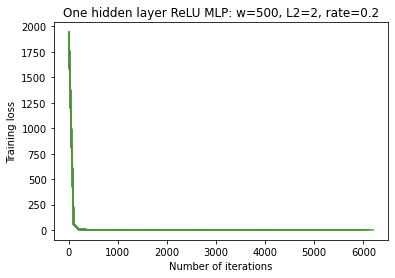

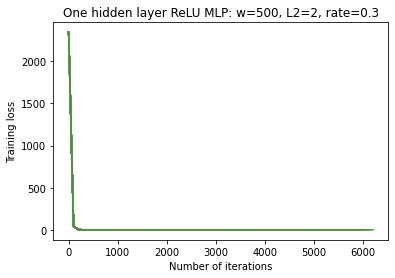

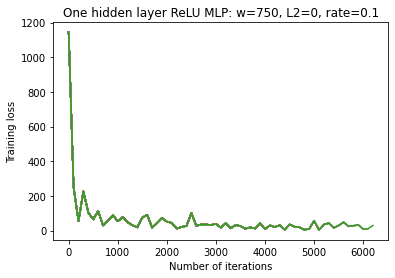

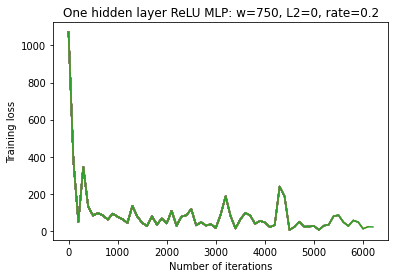

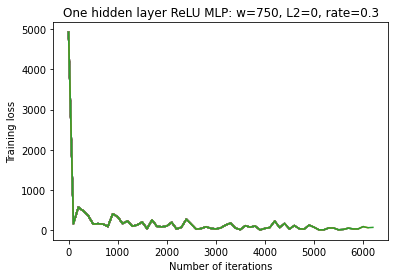

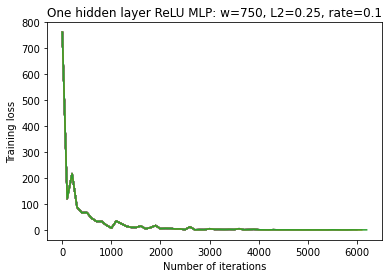

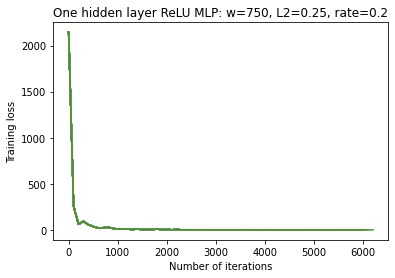

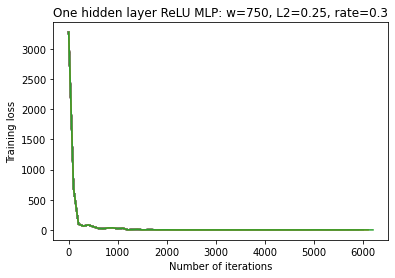

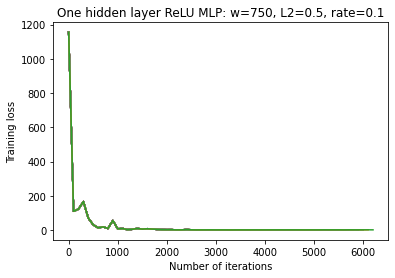

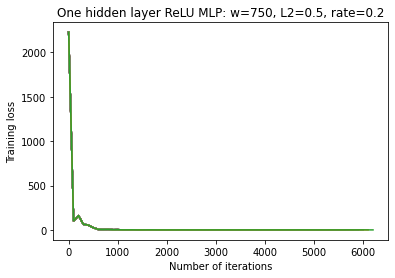

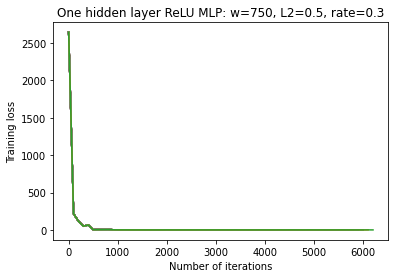

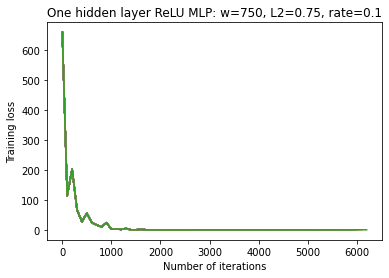

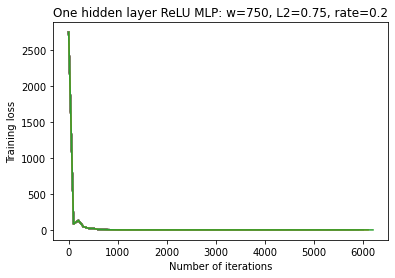

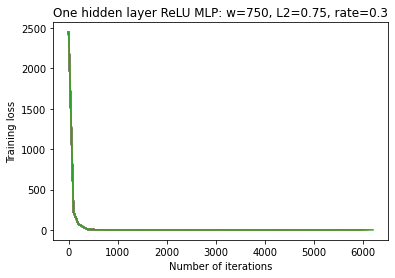

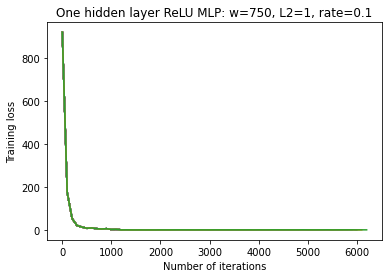

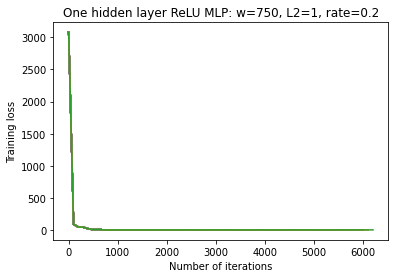

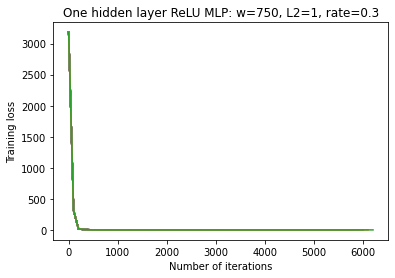

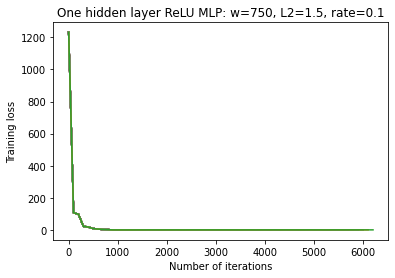

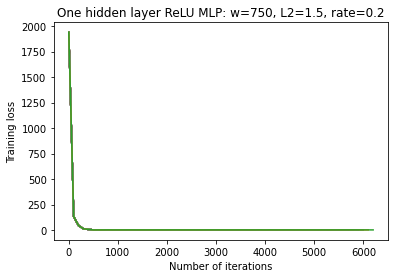

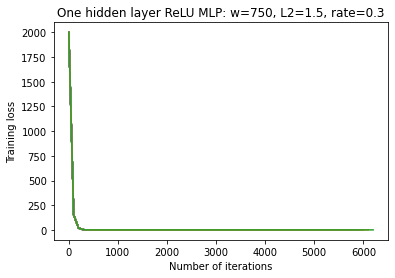

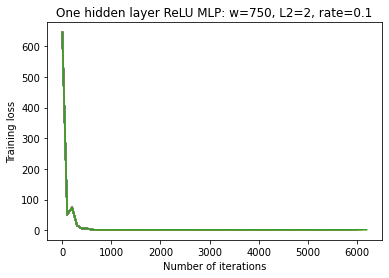

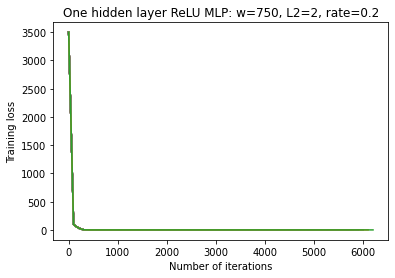

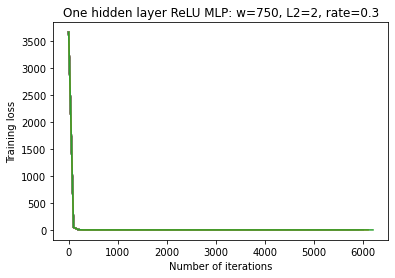

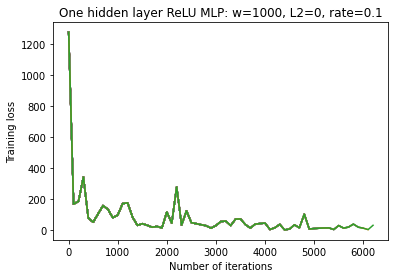

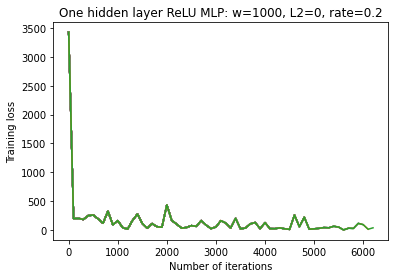

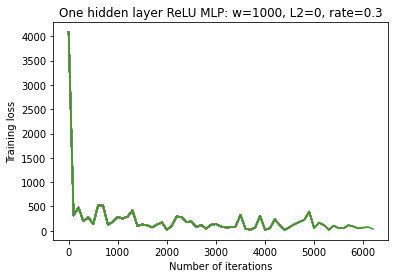

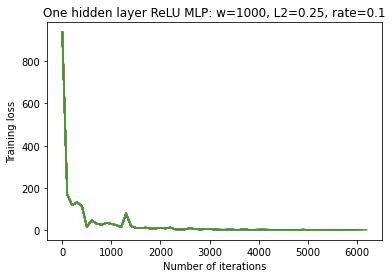

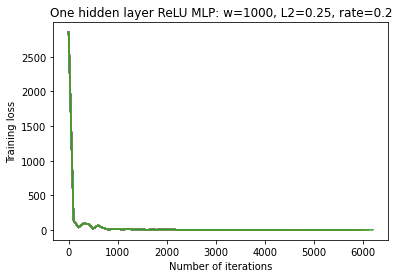

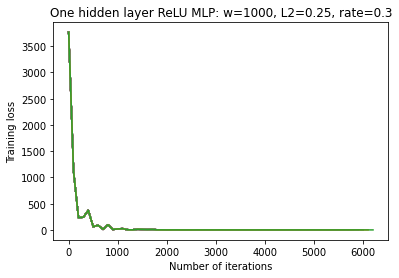

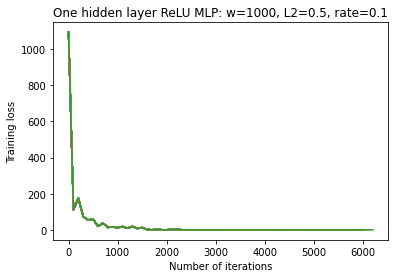

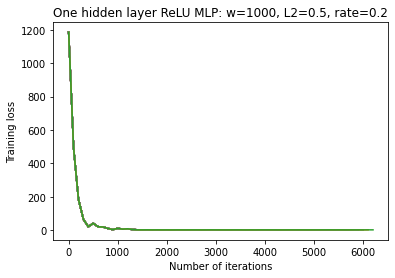

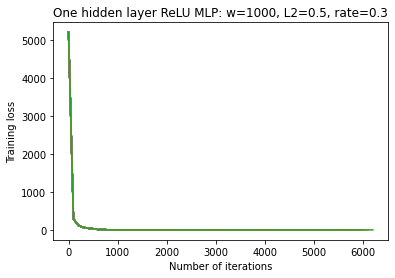

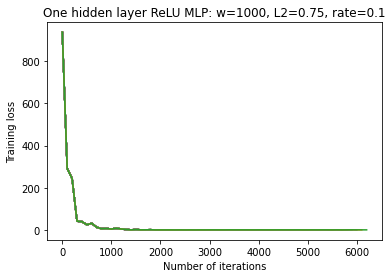

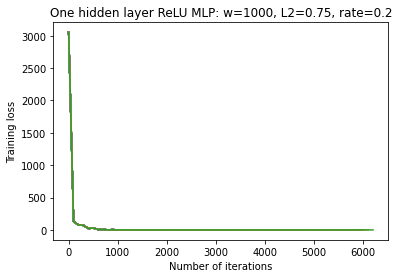

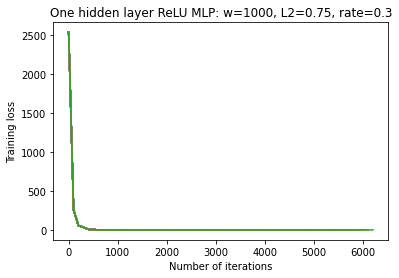

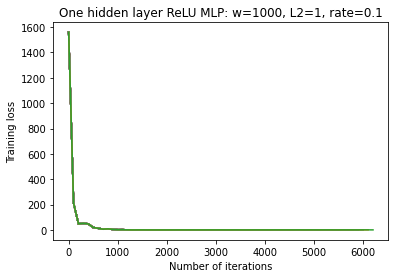

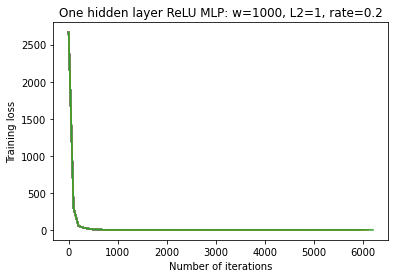

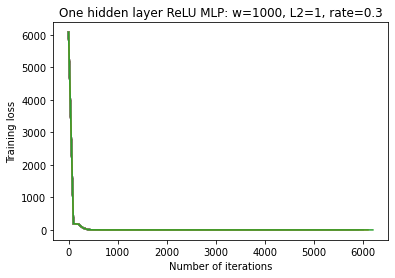

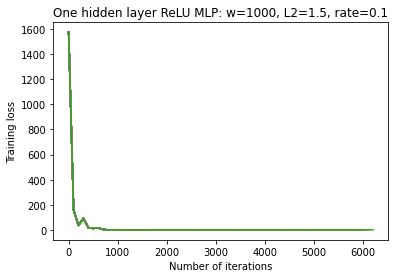

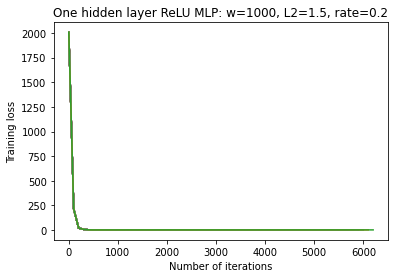

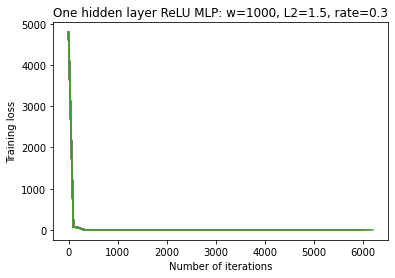

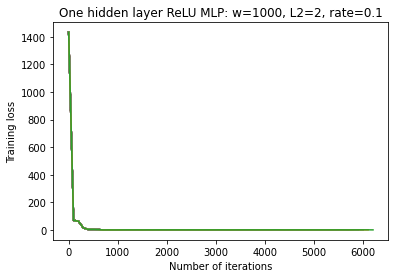

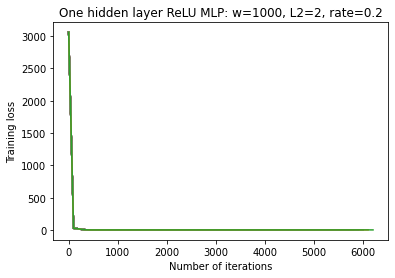

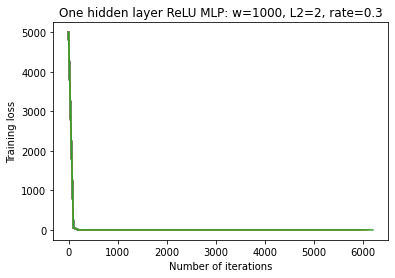

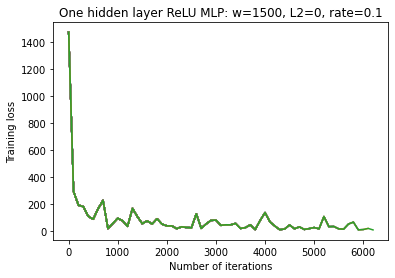

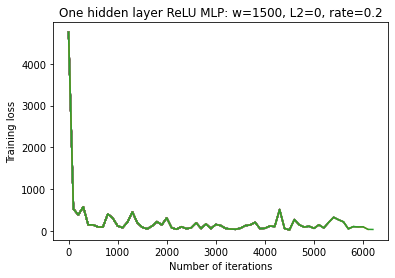

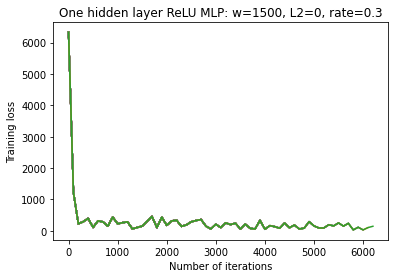

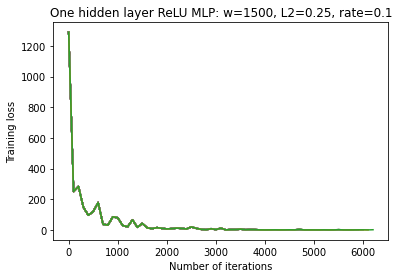

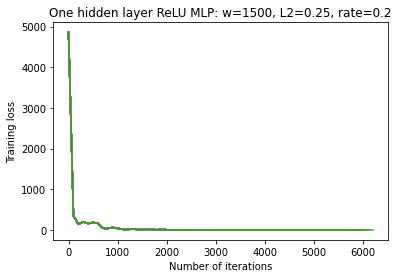

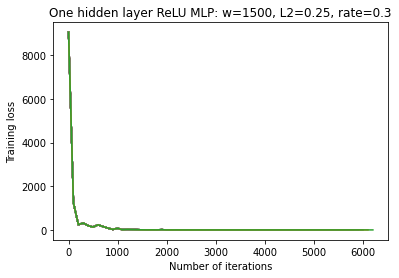

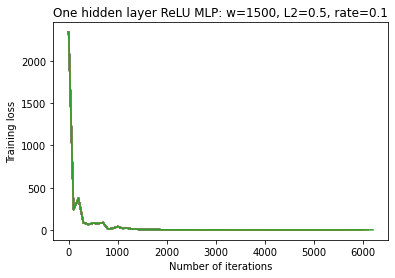

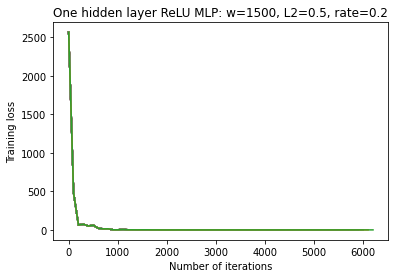

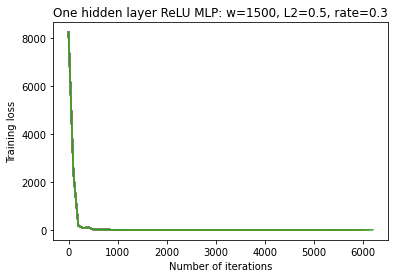

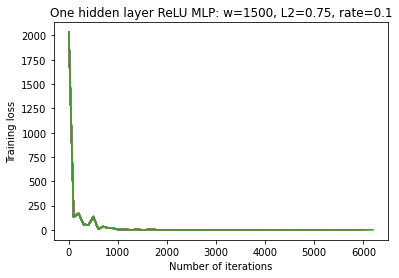

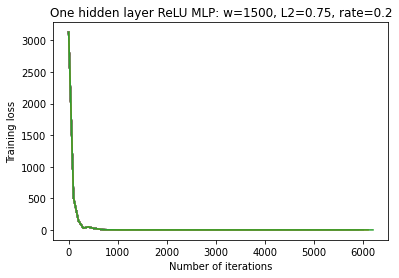

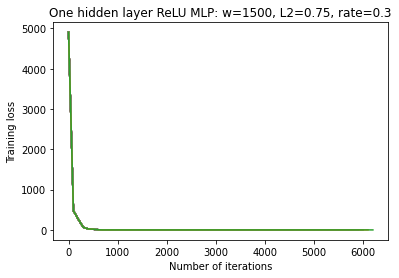

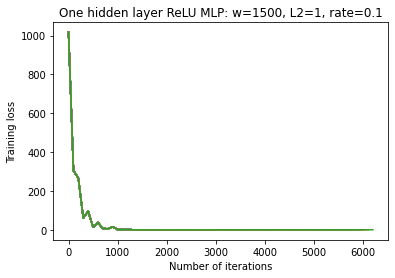

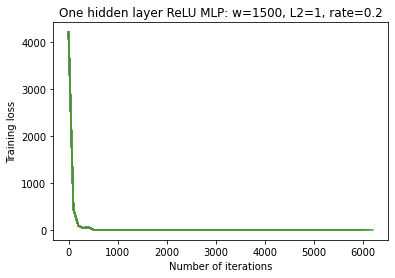

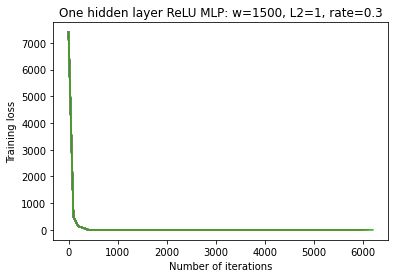

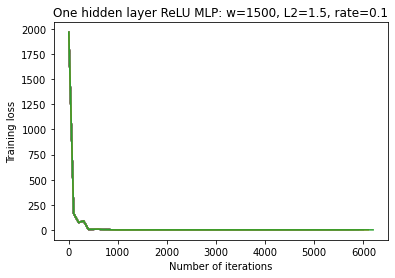

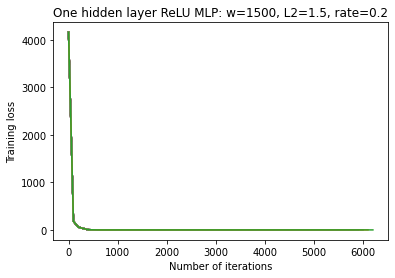

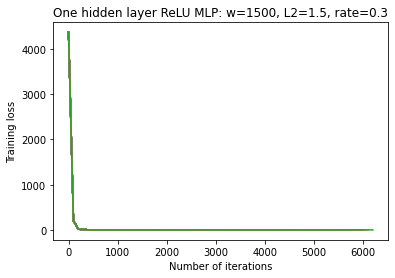

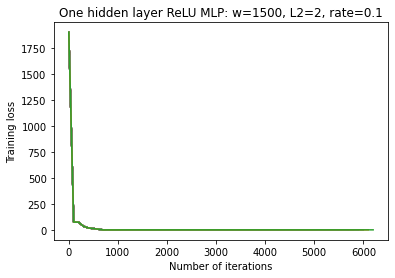

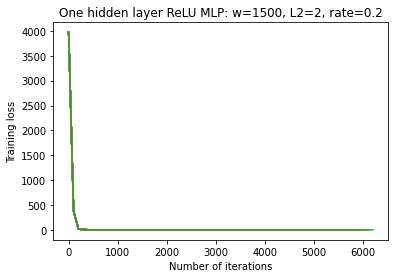

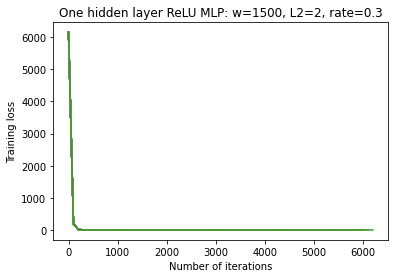

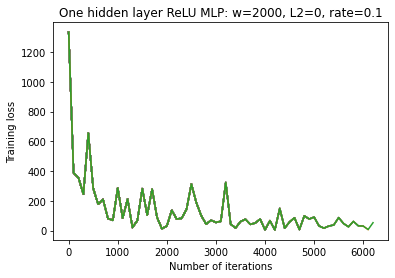

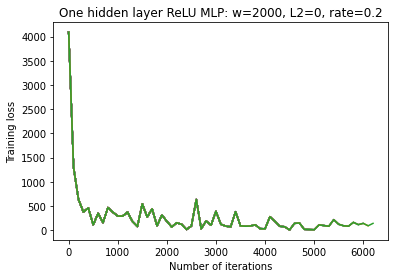

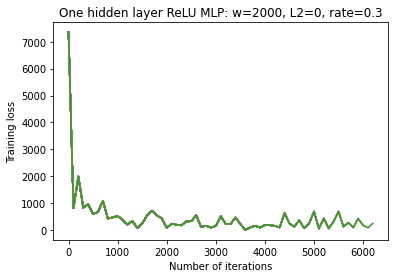

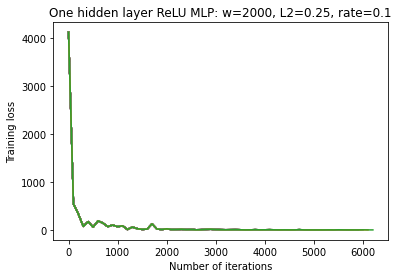

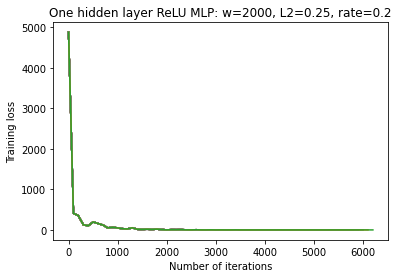

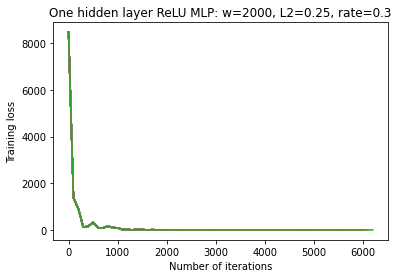

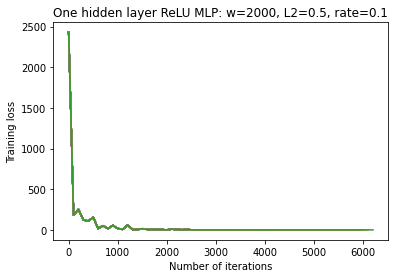

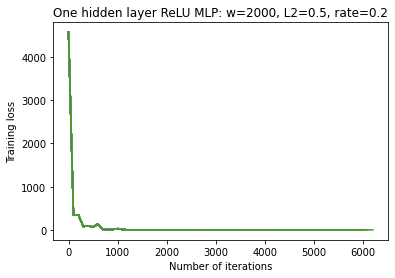

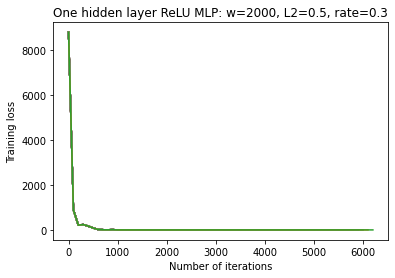

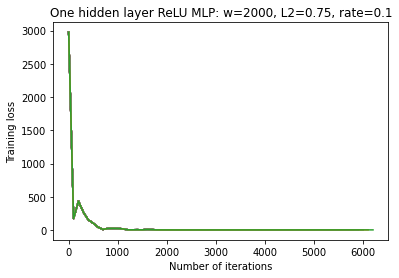

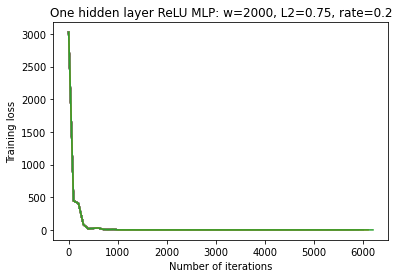

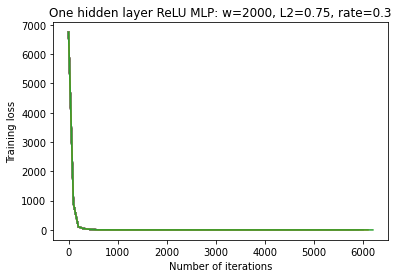

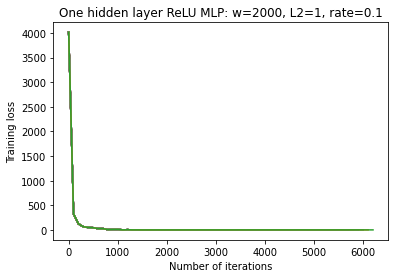

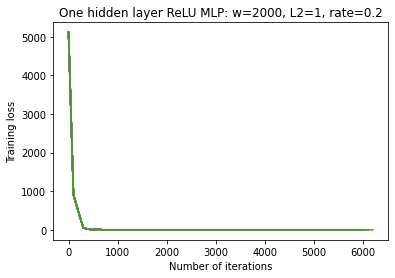

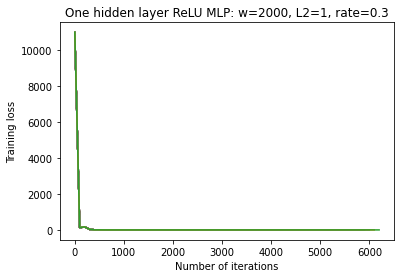

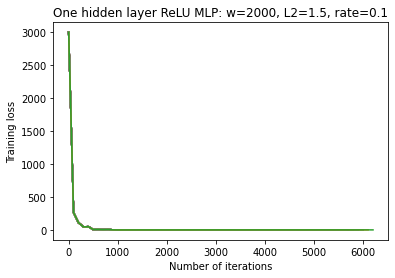

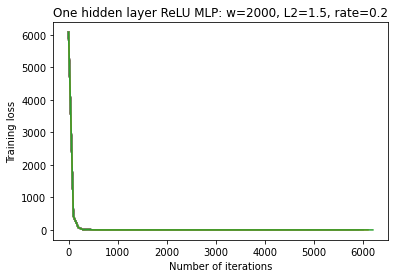

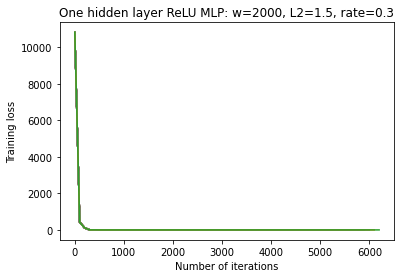

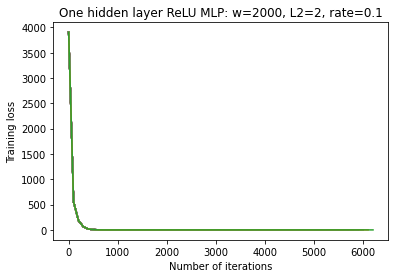

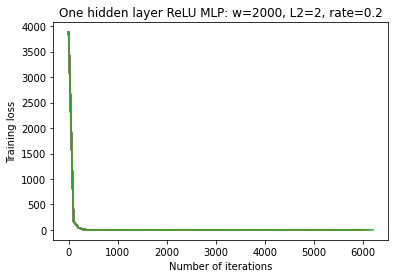

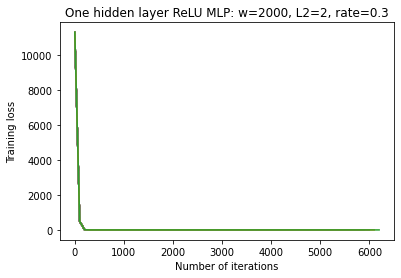

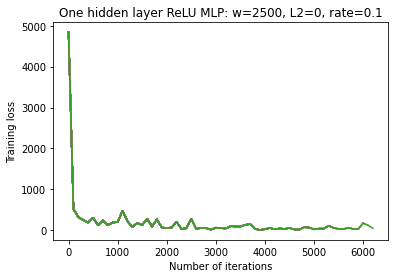

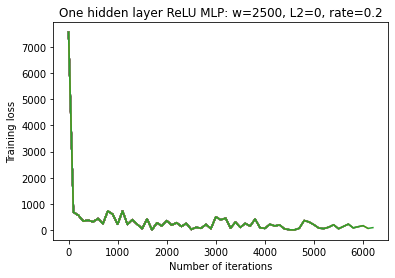

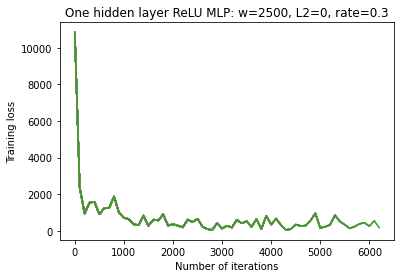

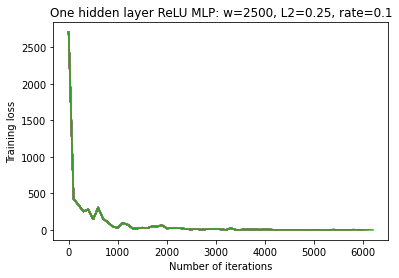

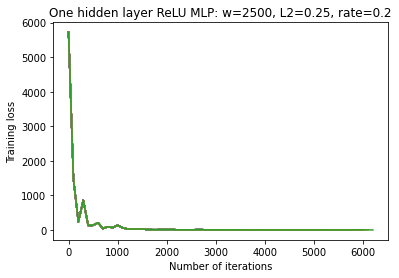

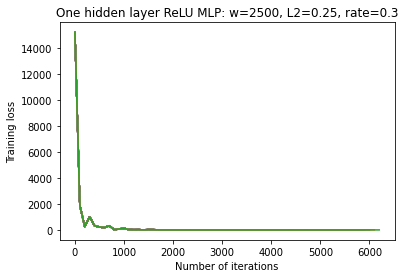

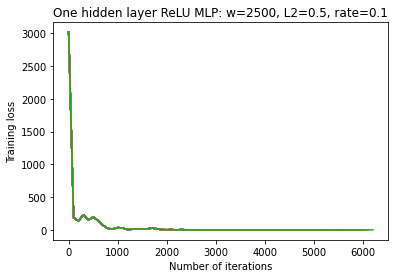

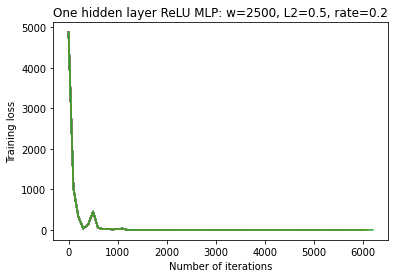

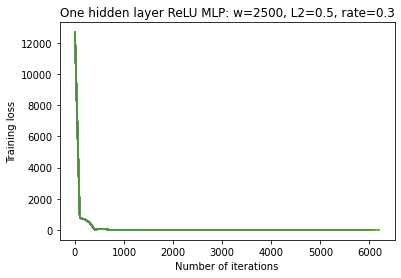

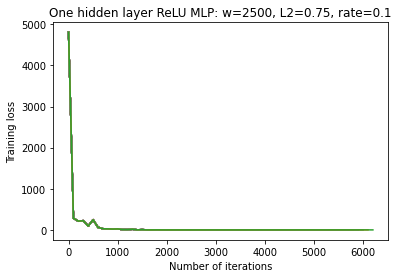

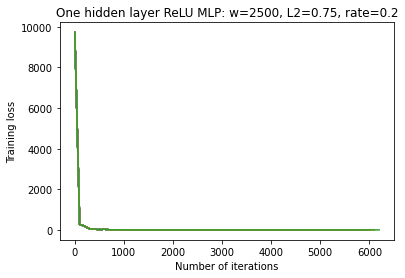

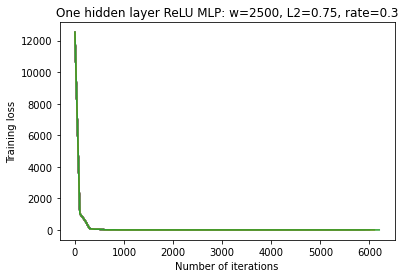

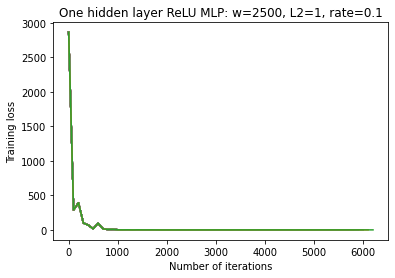

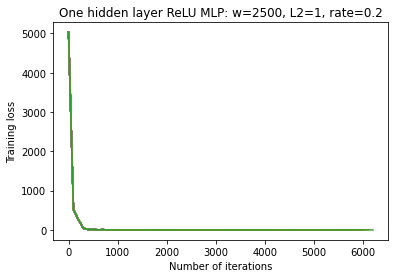

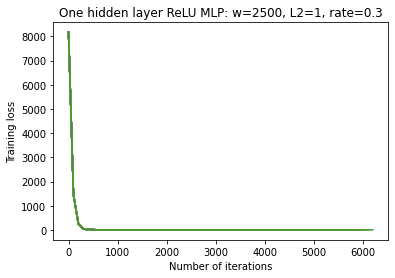

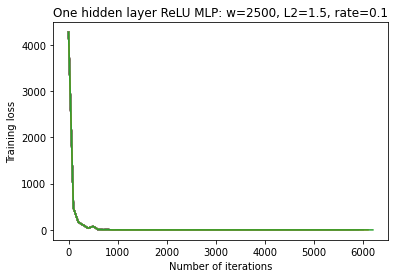

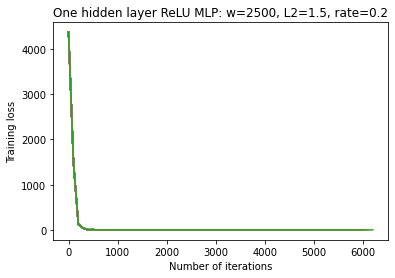

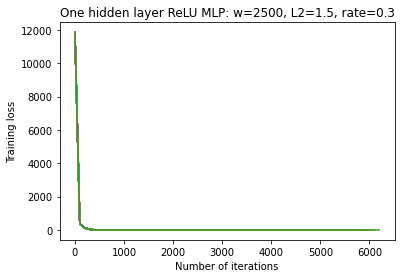

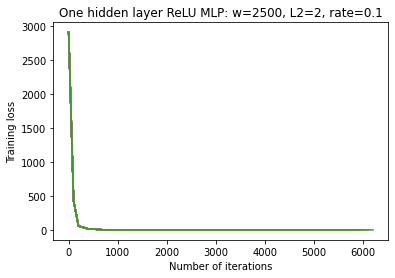

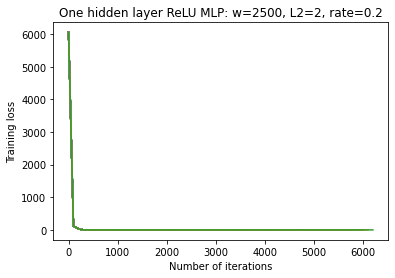

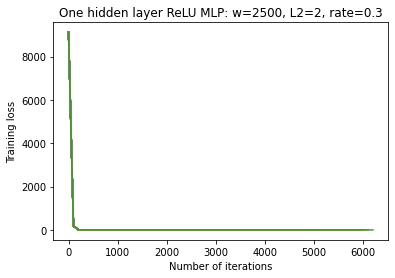

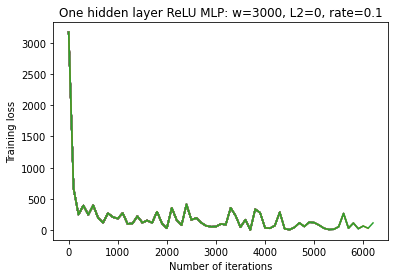

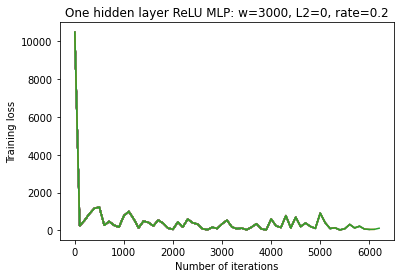

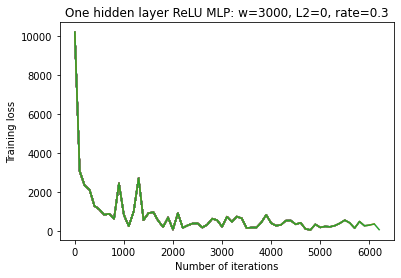

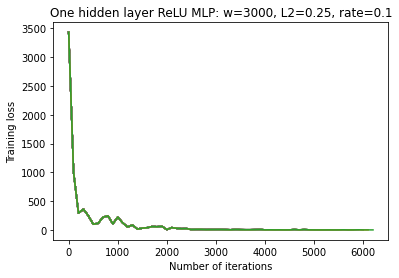

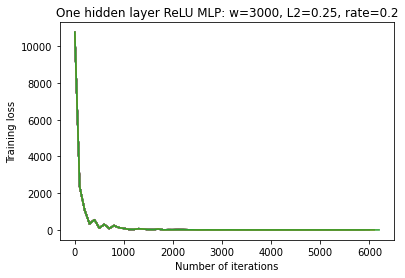

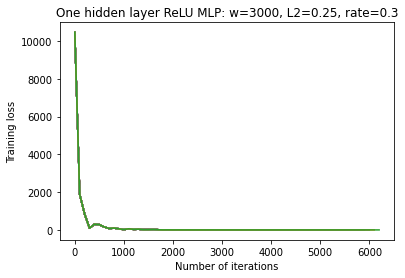

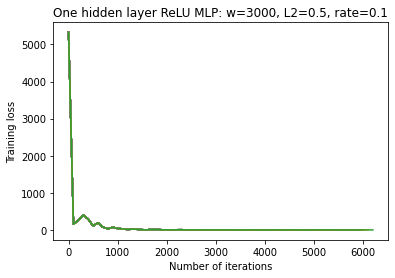

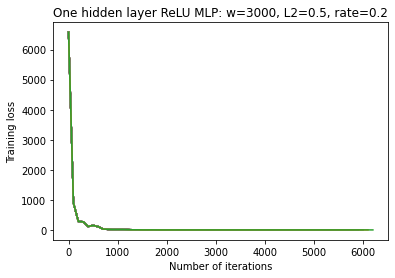

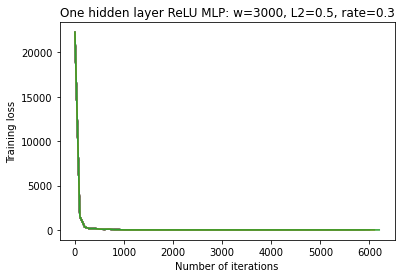

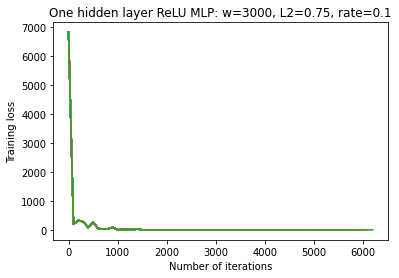

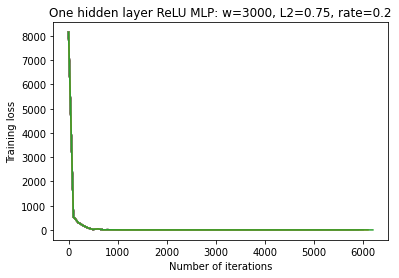

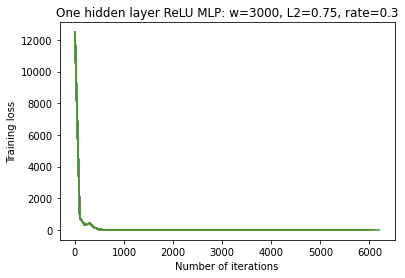

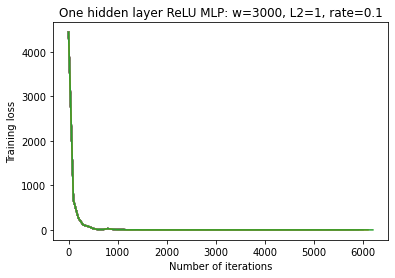

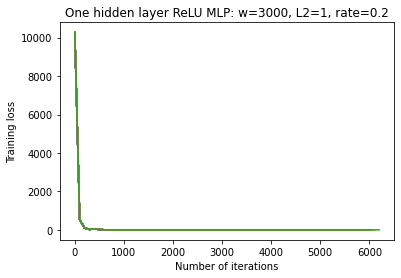

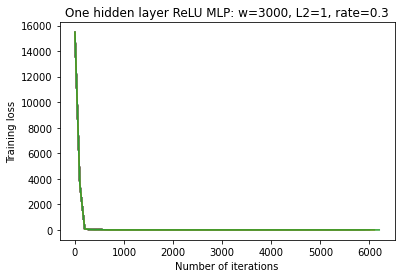

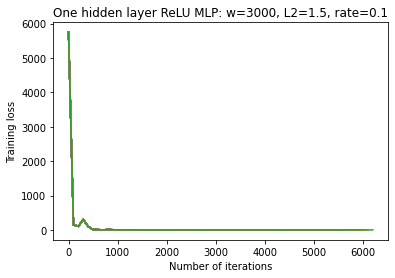

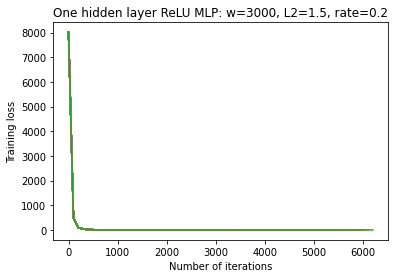

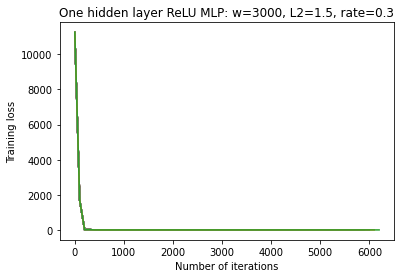

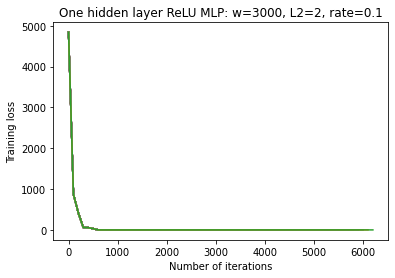

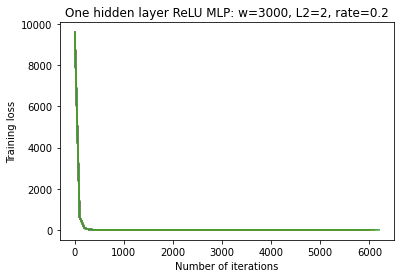

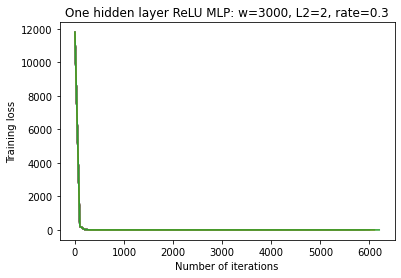

In [0]:
### Script for running experiments - one hidden layer ReLU

### Start by loading train and test sets. Split trainset into training data (80% of original data) and validation set (20%)

# Load images as Tensor objects and normalize to range [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# DataLoader simplifies minibatch SGD by returning a randomly-selected batch of training examples for each call to dataiter.next()
# Batch size given by batch_size parameter
batch_size = 64
traindata = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Split training set into train (40,000 examples) and validation (10,000 examples)
trainset, valset = torch.utils.data.random_split(traindata, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define parameters to test

widths = [250,500,750,1000,1500,2000,2500,3000]
regularization = [0,0.25,0.5,0.75,1,1.5,2]
lr = [0.1,0.2,0.3]

for w in widths:
  for reg in regularization:
    for rate in lr:
      lc_title = 'One hidden layer ReLU MLP: w=' + str(w) + ', L2=' + str(reg) + ', rate=' + str(rate)
      # Train MLP
      neural_network = OneLayerReLUMLP(w,3072,10,reg,10,rate,batch_size)
      iter_num,loss_values = neural_network.fit()

      # Compute validation loss
      valloader = torch.utils.data.DataLoader(valset, batch_size=10000,
                                         shuffle=True, num_workers=2)
      valiter = iter(valloader) 
      # Generate minibatch of N training examples and flatten them into an NxD tensor
      val_images,val_labels = valiter.next()
      X_val = torch.flatten(val_images,start_dim=1)
      X_val = X_val.float().cuda()

      # Convert labels to one-hot format
      batch = 10000
      C = 10
      y_val = torch.zeros(batch,C)
      y_val.scatter_(1,val_labels.unsqueeze(-1).repeat(1,C),torch.ones(batch,C))
      y_val = y_val.float().cuda()

      y_hat_val = neural_network.predict(X_val)
      acc = neural_network.evaluate_acc(y_hat_val,y_val)
      print(lc_title + '. Validation accuracy: ' + str(acc.item()))


Files already downloaded and verified
Files already downloaded and verified


(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([2405.18969727,  306.34954834,  383.79766846,  270.30758667,
         248.06307983,  125.94155884,   87.18223572]))

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([ 21.36610413, 125.95150757,  26.72948837,  26.90590477,
         77.63265991,  31.52252197,  40.33454895]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([17.24547958, 16.598032  , 14.24452305, 19.59097481,  8.76377296,
         4.90252638,  6.49275208]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([8.85788918, 4.3654089 , 6.08508682, 2.73456907, 9.09563541,
        2.55123043, 1.0723784 ]))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([2.21178198, 1.29457152, 2.02422976, 0.97745264, 0.53684378,
        0.63313884, 0.88143015]))

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.67179537, 0.79833162, 0.447128  , 0.74694026, 0.64694011,
        1.41462147, 0.56379211]))

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.52510422, 0.45741236, 0.51894283, 0.56853926, 0.6563971 ,
        0.57221514, 0.47254658]))

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.67764634, 0.40387297, 0.68131256, 0.67251813, 0.615022  ,
        0.73213422, 0.74350238]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.54077375, 0.64100844, 0.64482117, 0.7638182 , 0.79969025,
        0.69843483, 0.67524201]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.67950189, 0.76042873, 0.76790261, 0.88514209, 1.00044584,
        0.83261979, 0.91482759]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.8609302 , 0.80444694, 0.84514904, 0.7587738 , 0.83796757,
        0.91913164, 1.03276241]))

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.8427614 , 0.85847139, 0.62357891, 0.89530361, 0.73868728,
        0.9477886 , 0.7755692 ]))

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.63491547, 0.83211863, 0.94028872, 0.70109999, 0.81729102,
        0.86715269, 0.77999473]))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.78132755, 0.81063378, 0.83852154, 0.85145509, 0.9523685 ,
        0.85557342, 0.8545115 ]))

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.89675117, 0.90199995, 0.7865662 , 0.76192856, 0.83811641,
        0.86453843, 1.064659  ]))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.81535935, 0.88330144, 0.80391765, 0.92337614, 0.6967299 ,
        0.8498081 , 0.94391304]))

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.85941368, 0.82867956, 1.0908494 , 0.73301566, 0.7852087 ,
        0.95707887, 0.87956989]))

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.85857368, 0.81526899, 0.78116381, 1.00609124, 0.82755566,
        0.83623391, 0.99883324]))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.78745961, 0.80979097, 0.76237512, 0.92141509, 1.00911224,
        0.89377582, 0.88061798]))

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([0.82504034, 1.01581216, 0.88957655, 0.76331848, 0.87309933,
        0.85704625, 0.83185303]))

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Accuracy across epochs: Best ReLU MLP')

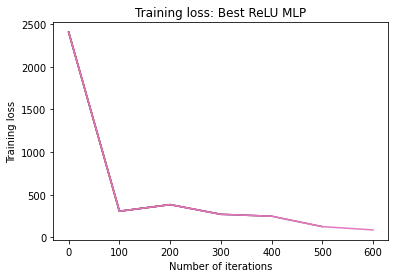

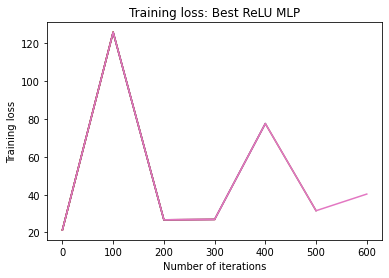

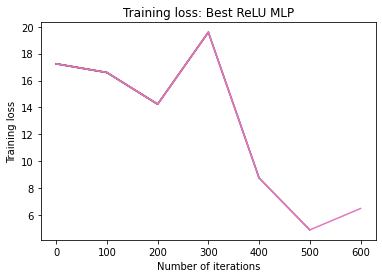

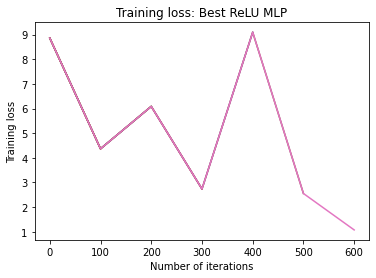

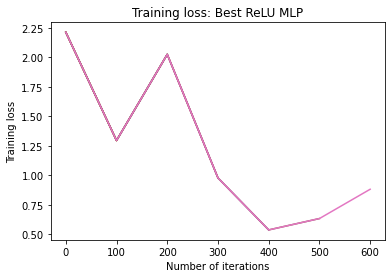

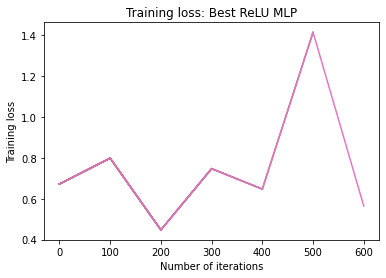

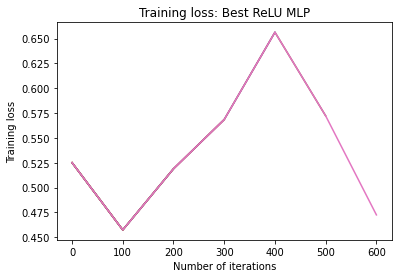

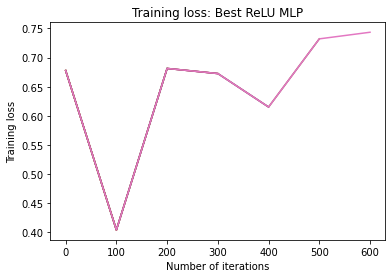

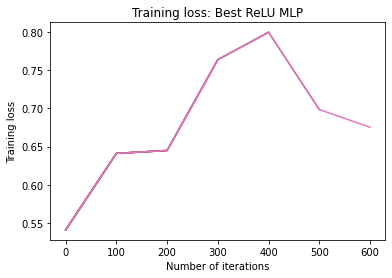

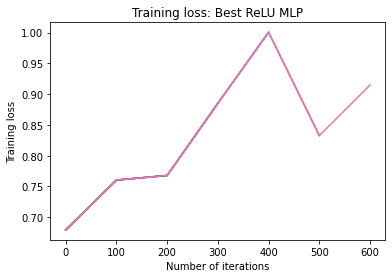

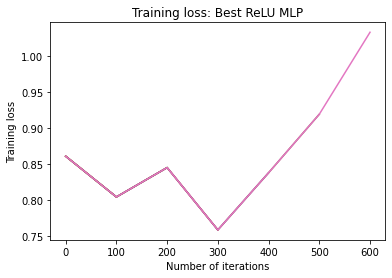

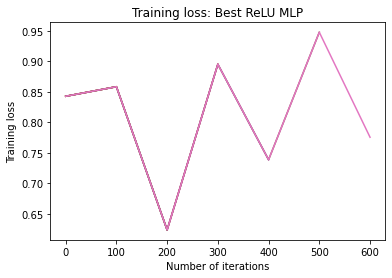

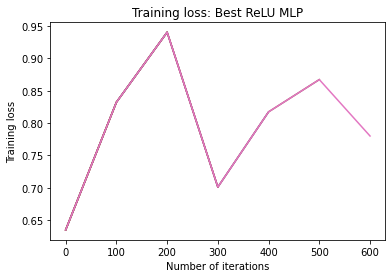

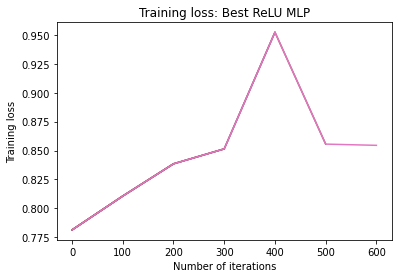

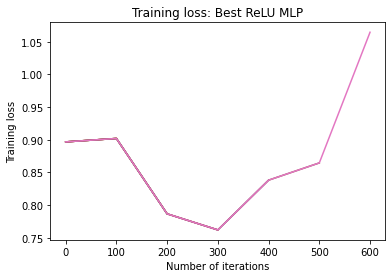

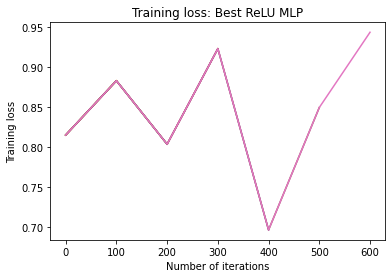

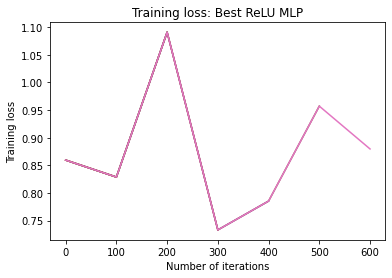

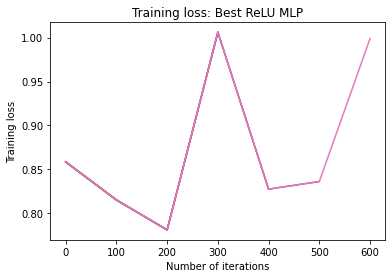

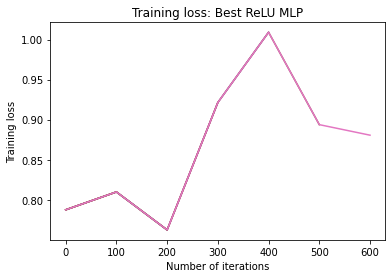

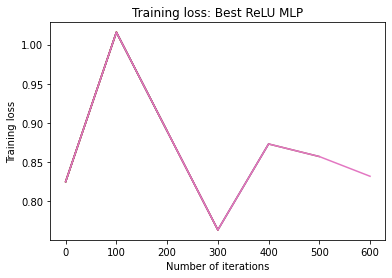

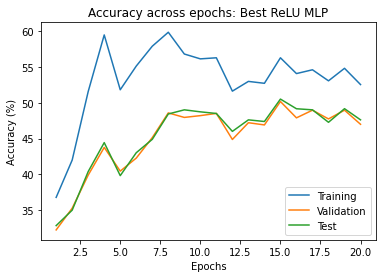

In [0]:
### Script to run final ReLU tests and compute epoch-vs-accuracy data

### Start by loading train and test sets.

# Load images as Tensor objects and normalize to range [-1,1]
# Load images as Tensor objects and normalize to range [-1,1]
augmented_transform = transforms.Compose(
    [transforms.RandomChoice([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=30), transforms.RandomVerticalFlip(p=0.5)]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# DataLoader simplifies minibatch SGD by returning a randomly-selected batch of training examples for each call to dataiter.next()
# Batch size given by batch_size parameter
batch_size = 64
traindata = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Split training set into train (40,000 examples) and validation (10,000 examples)
trainset, valset = torch.utils.data.random_split(traindata, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=10000,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Define array of train, validation and test accuracies

train_acc_values = np.array([])
val_acc_values = np.array([])
test_acc_values = np.array([])
epoch_num = np.array([])

# Best ReLU params are width=3000, L2 param=0.5, learning rate=0.1. Allow to train for 10 epochs and track accuracies.

best_mlp = OneLayerReLUMLP(3000,3072,10,0.5,1,0.1,batch_size)

epoch = 0

while epoch<20:
  # train MLP for one epoch
  best_mlp.fit()
  # evaluate accuracy on train, val, test sets
  # Compute training accuracy
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=40000,
                                          shuffle=True, num_workers=2)
  trainiter = iter(trainloader) 
  # Generate minibatch of N training examples and flatten them into an NxD tensor
  train_images,train_labels = trainiter.next()
  X_train = torch.flatten(train_images,start_dim=1)
  X_train = X_train.float().cuda()

  # Convert labels to one-hot format
  batch = 40000
  C = 10
  y_train = torch.zeros(batch,C)
  y_train.scatter_(1,train_labels.unsqueeze(-1).repeat(1,C),torch.ones(batch,C))
  y_train = y_train.float().cuda()

  y_hat_train = best_mlp.predict(X_train)
  train_acc = best_mlp.evaluate_acc(y_hat_train,y_train)
  train_acc_values = np.append(train_acc_values,train_acc.cpu())
  # Compute validation accuracy
  valloader = torch.utils.data.DataLoader(valset, batch_size=10000,
                                         shuffle=True, num_workers=2)
  valiter = iter(valloader) 
  # Generate minibatch of N training examples and flatten them into an NxD tensor
  val_images,val_labels = valiter.next()
  X_val = torch.flatten(val_images,start_dim=1)
  X_val = X_val.float().cuda()

  # Convert labels to one-hot format
  batch = 10000
  C = 10
  y_val = torch.zeros(batch,C)
  y_val.scatter_(1,val_labels.unsqueeze(-1).repeat(1,C),torch.ones(batch,C))
  y_val = y_val.float().cuda()

  y_hat_val = best_mlp.predict(X_val)
  val_acc = best_mlp.evaluate_acc(y_hat_val,y_val)
  val_acc_values = np.append(val_acc_values,val_acc.cpu())
  # Compute test accuracy
  testiter = iter(testloader) 
  # Generate minibatch of N training examples and flatten them into an NxD tensor
  test_images,test_labels = testiter.next()
  X_test = torch.flatten(test_images,start_dim=1)
  X_test = X_test.float().cuda()

  # Convert labels to one-hot format
  batch = 10000
  C = 10
  y_test = torch.zeros(batch,C)
  y_test.scatter_(1,test_labels.unsqueeze(-1).repeat(1,C),torch.ones(batch,C))
  y_test = y_test.float().cuda()

  y_hat_test = best_mlp.predict(X_test)
  test_acc = best_mlp.evaluate_acc(y_hat_test,y_test)
  test_acc_values = np.append(test_acc_values,test_acc.cpu())

  epoch = epoch+1
  epoch_num = np.append(epoch_num,epoch)

# Now plot results
plt.figure()
plt.plot(epoch_num,train_acc_values, label = 'Training')
plt.plot(epoch_num,val_acc_values, label = 'Validation')
plt.plot(epoch_num,test_acc_values, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy across epochs: Best ReLU MLP')
plt.legend()

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Accuracy across epochs: Best ReLU MLP')

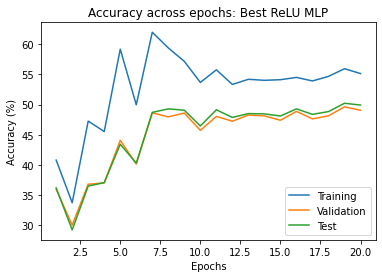

In [0]:
# Now plot results
plt.figure()
plt.plot(epoch_num,train_acc_values, label = 'Training')
plt.plot(epoch_num,val_acc_values, label = 'Validation')
plt.plot(epoch_num,test_acc_values, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy across epochs: Best ReLU MLP')
plt.legend()
plt.savefig('accuracy_epoch_ReLU_MLP.png', dpi=600)

Files already downloaded and verified
Files already downloaded and verified


(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([12.33708096,  6.63249111,  5.9297123 ,  4.2965889 ,  3.94723558,
         3.43146276,  3.85486245]))

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([3.01718688, 2.77551675, 2.91496277, 2.91431236, 2.26406622,
        2.79167676, 2.00092602]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([2.1428957 , 1.99311006, 2.0437398 , 1.79763246, 2.17118907,
        1.92462099, 1.65843487]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.5265609 , 1.77696681, 1.70031691, 1.60192895, 1.63948393,
        1.67040777, 1.50238204]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.66110182, 1.6313405 , 1.58250439, 1.41112161, 1.52953053,
        1.7027669 , 1.76155782]))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.89349556, 1.45351481, 1.59030104, 1.43076611, 1.78285193,
        1.87020123, 1.51451063]))

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.82780159, 1.45794463, 1.5833391 , 1.54022467, 1.59567547,
        1.48389387, 1.44476438]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.48621678, 1.38197303, 1.5373646 , 1.75905025, 1.51515412,
        1.55833936, 1.43564844]))

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.64760685, 1.61756086, 1.58834314, 1.49311543, 1.5211978 ,
        1.58584428, 1.48423421]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.44099784, 1.7338388 , 1.51721644, 1.4002099 , 1.3985045 ,
        1.45075774, 1.49016464]))

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.59133816, 1.60633481, 1.35444665, 1.36468768, 1.29918933,
        1.30560625, 1.3662194 ]))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.22687912, 1.442927  , 1.41946304, 1.48842239, 1.37965322,
        1.56609726, 1.46616137]))

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.35290325, 1.51344466, 1.53619075, 1.49593329, 1.43113399,
        1.53171039, 1.57825208]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.56543016, 1.43000579, 1.41313577, 1.5081346 , 1.54921567,
        1.37092924, 1.46194184]))

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.54170597, 1.5192101 , 1.42321181, 1.26171172, 1.56760073,
        1.19171965, 1.31859589]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.34935236, 1.67743075, 1.44472325, 1.61946404, 1.43389535,
        1.55669093, 1.32389665]))

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.37060499, 1.43972337, 1.45312357, 1.51910996, 1.57341385,
        1.49433875, 1.4576019 ]))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.44624424, 1.49307013, 1.49467981, 1.42291045, 1.34440804,
        1.50717437, 1.35429192]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.48278642, 1.26130998, 1.4139055 , 1.57474577, 1.43226278,
        1.3816067 , 1.35823572]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

(array([  0., 100., 200., 300., 400., 500., 600.]),
 array([1.33514869, 1.53406346, 1.3984338 , 1.62852478, 1.33313632,
        1.41980457, 1.56037962]))

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Accuracy across epochs: Best Sigmoid MLP')

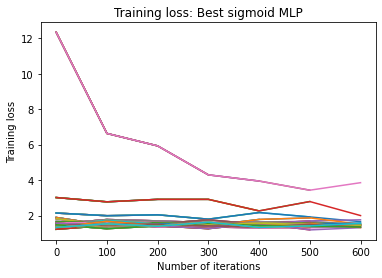

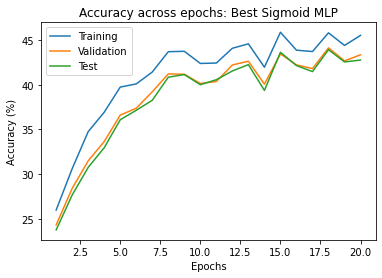

In [0]:
### Script to run final sigmoid tests and compute epoch-vs-accuracy data

### Start by loading train and test sets.

# Load images as Tensor objects and normalize to range [-1,1]
augmented_transform = transforms.Compose(
    [transforms.RandomChoice([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=30), transforms.RandomVerticalFlip(p=0.5)]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# DataLoader simplifies minibatch SGD by returning a randomly-selected batch of training examples for each call to dataiter.next()
# Batch size given by batch_size parameter
batch_size = 64
traindata = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Split training set into train (40,000 examples) and validation (10,000 examples)
trainset, valset = torch.utils.data.random_split(traindata, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=10000,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Define array of train, validation and test accuracies

train_acc_values = np.array([])
val_acc_values = np.array([])
test_acc_values = np.array([])
epoch_num = np.array([])

# Best sigmoid params are width=250, L2 param=0.25, learning rate=0.1. Allow to train for 20 epochs and track accuracies.

best_mlp = OneLayerSigMLP(250,3072,10,0.25,1,0.1,batch_size)

epoch = 0

while epoch<20:
  # train MLP for one epoch
  best_mlp.fit()
  # evaluate accuracy on train, val, test sets
  # Compute training accuracy
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=40000,
                                          shuffle=True, num_workers=2)
  trainiter = iter(trainloader) 
  # Generate minibatch of N training examples and flatten them into an NxD tensor
  train_images,train_labels = trainiter.next()
  X_train = torch.flatten(train_images,start_dim=1)
  X_train = X_train.float().cuda()

  # Convert labels to one-hot format
  batch = 40000
  C = 10
  y_train = torch.zeros(batch,C)
  y_train.scatter_(1,train_labels.unsqueeze(-1).repeat(1,C),torch.ones(batch,C))
  y_train = y_train.float().cuda()

  y_hat_train = best_mlp.predict(X_train)
  train_acc = best_mlp.evaluate_acc(y_hat_train,y_train)
  train_acc_values = np.append(train_acc_values,train_acc.cpu())
  # Compute validation accuracy
  valloader = torch.utils.data.DataLoader(valset, batch_size=10000,
                                         shuffle=True, num_workers=2)
  valiter = iter(valloader) 
  # Generate minibatch of N training examples and flatten them into an NxD tensor
  val_images,val_labels = valiter.next()
  X_val = torch.flatten(val_images,start_dim=1)
  X_val = X_val.float().cuda()

  # Convert labels to one-hot format
  batch = 10000
  C = 10
  y_val = torch.zeros(batch,C)
  y_val.scatter_(1,val_labels.unsqueeze(-1).repeat(1,C),torch.ones(batch,C))
  y_val = y_val.float().cuda()

  y_hat_val = best_mlp.predict(X_val)
  val_acc = best_mlp.evaluate_acc(y_hat_val,y_val)
  val_acc_values = np.append(val_acc_values,val_acc.cpu())
  # Compute test accuracy
  testiter = iter(testloader) 
  # Generate minibatch of N training examples and flatten them into an NxD tensor
  test_images,test_labels = testiter.next()
  X_test = torch.flatten(test_images,start_dim=1)
  X_test = X_test.float().cuda()

  # Convert labels to one-hot format
  batch = 10000
  C = 10
  y_test = torch.zeros(batch,C)
  y_test.scatter_(1,test_labels.unsqueeze(-1).repeat(1,C),torch.ones(batch,C))
  y_test = y_test.float().cuda()

  y_hat_test = best_mlp.predict(X_test)
  test_acc = best_mlp.evaluate_acc(y_hat_test,y_test)
  test_acc_values = np.append(test_acc_values,test_acc.cpu())

  epoch = epoch+1
  epoch_num = np.append(epoch_num,epoch)

# Now plot results
plt.figure()
plt.plot(epoch_num,train_acc_values, label = 'Training')
plt.plot(epoch_num,val_acc_values, label = 'Validation')
plt.plot(epoch_num,test_acc_values, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy across epochs: Best Sigmoid MLP')
plt.legend()

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Accuracy across epochs: Best Sigmoid MLP')

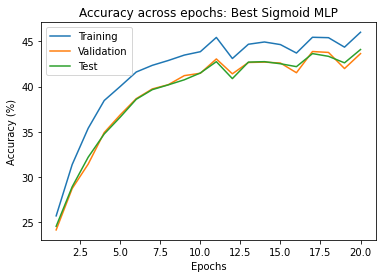

In [0]:
# Now plot results
plt.figure()
plt.plot(epoch_num,train_acc_values, label = 'Training')
plt.plot(epoch_num,val_acc_values, label = 'Validation')
plt.plot(epoch_num,test_acc_values, label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy across epochs: Best Sigmoid MLP')
plt.legend()
plt.savefig('accuracy_epoch_sigmoid_MLP.png', dpi=600)